In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree
from scipy import stats

In [2]:
caminho_arquivo = './dados/MICRODADOS_ENEM_2018.csv'
data = pd.read_csv(caminho_arquivo, encoding='latin1', sep=';')
num_columns = data.shape[1]
num_rows = data.shape[0]
print(f"Número de colunas: {num_columns}")
print(f"Número de linhas: {num_rows}")
data.head()

Número de colunas: 78
Número de linhas: 5513733


,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,180007186625,2018,2,F,0.0,4,1,2,0,4,...,B,C,B,B,D,B,C,B,B,D
1,180007186627,2018,3,F,0.0,4,1,1,1,1,...,A,B,A,A,B,A,A,A,A,A
2,180007186628,2018,3,M,0.0,0,1,2,0,2,...,A,B,B,A,D,A,A,A,B,A
3,180007186629,2018,2,F,0.0,3,1,2,0,4,...,A,C,A,B,D,B,A,B,B,B
4,180007186631,2018,11,F,0.0,5,1,1,6,1,...,A,B,B,A,C,A,B,A,A,A


In [3]:
#Funções

#função tratar nulos
def tratarNulos(dados):
    dataset = dados.copy()  # evita problemas de referência
    
    # Colunas numéricas que representam categorias
    colunas_categoricas_numericas = [
        'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
        'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
        'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC','Q006',
        'Q007','Q008','Q009','Q010','Q011','Q012','Q013','Q014','Q015','Q016','Q017','Q018','Q019'
    ]
    
    for col in dataset.columns:
        if dataset[col].isnull().any():  # só trata se houver nulos
            if col in colunas_categoricas_numericas:
                # Para categóricas → moda
                moda = dataset[col].mode()
                if not moda.empty:
                    dataset[col] = dataset[col].fillna(moda.iloc[0])
            else:
                # Para numéricas contínuas → média
                media = dataset[col].mean()
                dataset[col] = dataset[col].fillna(media)
    
    return dataset



#Função analisar importância das features de forma agregada
def analisar_importancia_features_agregada(modelo, clf, titulo, top_n=None):
    """
    Exibe a importância das features de um modelo DecisionTreeClassifier,
    somando as importâncias das dummies das features categóricas.

    Parâmetros:
    - modelo: pipeline treinado (com preprocessador + classificador)
    - clf: classificador treinado (ex: DecisionTreeClassifier)
    - categoricas: lista de colunas categóricas originais
    - top_n: se quiser mostrar só as N variáveis mais importantes (opcional)

    Retorna:
    - df_agregado: DataFrame com importância agregada por feature
    """

    categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
    # Extrair nomes das features pós-transformação
    nomes_features = modelo.named_steps['preprocessador'].get_feature_names_out()
    
    # Importâncias
    importances = clf.feature_importances_
    
    # Criar DataFrame
    df = pd.DataFrame({
        'feature_expandida': nomes_features,
        'importancia': importances
    })
    
    # Inicializar coluna de feature original
    df['feature_original'] = df['feature_expandida']
    
    # Mapear dummies categóricas para a feature original
    for cat in categoricas:
        mask = df['feature_expandida'].str.contains(f"__{cat}_")
        df.loc[mask, 'feature_original'] = cat
    
    # Agregar importâncias por feature original
    df_agregado = df.groupby('feature_original')['importancia'].sum().sort_values(ascending=False)
    
    # Filtrar top_n se necessário
    if top_n:
        df_agregado = df_agregado.head(top_n)
    
    # Print em texto
    print("Importância das features (agregada):")
    for feat, imp in df_agregado.items():
        print(f"Feature {feat}: {imp:.4f}")
    
    # Gráfico
    plt.figure(figsize=(10,6))
    plt.barh(df_agregado.index, df_agregado.values)   # <-- barras horizontais
    plt.xlabel("Importância")                         # título do eixo X
    plt.ylabel("Features")                            # título do eixo Y
    plt.title(f"Importância das Features {titulo} (DecisionTreeClassifier)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return df_agregado


#Função analisar features de forma individual
def analisar_importancia_features(modelo, clf, titulo, top_n=None):
    """
    Exibe a importância individual das features (sem agregação) 
    de um modelo DecisionTreeClassifier treinado dentro de um pipeline.

    Parâmetros:
    - modelo: pipeline treinado (com preprocessador + classificador)
    - clf: classificador treinado (ex: DecisionTreeClassifier)
    - top_n: se quiser mostrar só as N variáveis mais importantes (opcional)

    Retorna:
    - df_importancias: DataFrame com importâncias individuais
    """

    # Extrair nomes das features após o pré-processamento
    nomes_features = modelo.named_steps['preprocessador'].get_feature_names_out()

    # Pegar as importâncias
    importances = clf.feature_importances_

    # Criar DataFrame
    df_importancias = pd.DataFrame({
        'feature': nomes_features,
        'importancia': importances
    }).sort_values(by='importancia', ascending=False)

    # Filtrar top_n se solicitado
    if top_n:
        df_importancias = df_importancias.head(top_n)

    # Print simples
    print("Importância das features (sem agregação):")
    for feat, imp in zip(df_importancias['feature'], df_importancias['importancia']):
        print(f"{feat}: {imp:.4f}")

    # Gráfico
    plt.figure(figsize=(10,6))
    plt.barh(df_importancias['feature'], df_importancias['importancia'])
    plt.xlabel("Importância")
    plt.ylabel("Feature")
    plt.title(f"Importância Individual das Features {titulo}(DecisionTreeClassifier)")
    plt.gca().invert_yaxis()  # deixa a mais importante no topo
    plt.tight_layout()
    plt.show()

    return df_importancias


#Função analisar desempenhos estatísticos(media, mediana, desvio padrão, quartis, valor minimo, valor maximo, amplitude e coeficiente de variação) pra cada classe de renda social
def analisar_desempenho_por_classe(dataset, nome_dataset, notas=['NU_NOTA_CH','NU_NOTA_CN','NU_NOTA_LC','NU_NOTA_MT','NU_NOTA_REDACAO']):
    """
    Analisa estatísticas das notas por classe social, incluindo média, mediana, 
    desvio padrão, variância, amplitude e coeficiente de variação.
    Garante ordenação correta das classes mesmo que haja variações de texto.
    """

    # Criar coluna de média das notas
    dataset['media_notas'] = dataset[notas].mean(axis=1)

    # Funções auxiliares
    def calc_amplitude(x):
        return x.max() - x.min()

    def calc_cv(x):
        return (x.std() / x.mean()) * 100 if x.mean() != 0 else np.nan

    # Agrupar por classe social
    resumo = dataset.groupby('classe_social')['media_notas'].agg(
        media='mean',
        mediana='median',
        desvio_padrao='std',
        variancia='var',
        q1=lambda x: np.percentile(x, 25),
        q3=lambda x: np.percentile(x, 75),
        valor_minimo='min',
        valor_maximo='max',
        amplitude=calc_amplitude,
        coef_var=calc_cv
    ).reset_index()

    # Dicionário para garantir ordem correta das classes
    ordem_classes = {
        "Até 2 salários mínimos": 1,
        "De 2 a 3 salários mínimos": 2,
        "De 3 a 6 salários mínimos": 3,
        "De 6 a 10 salários mínimos": 4,
        "De 10 a 15 salários mínimos": 5,
        "Acima de 15 salários mínimos": 6
    }

    # Mapeamento seguro: procurar substring correspondente
    def mapear_ordem(classe):
        for nome, ordem in ordem_classes.items():
            if nome in classe:
                return ordem
        return np.nan  # caso alguma classe não bata exatamente

    resumo['ordem'] = resumo['classe_social'].apply(mapear_ordem)

    # Ordenar de fato
    resumo = resumo.sort_values('ordem')

    # Imprimir tabela
    print(f"\nResumo estatístico completo por classe social {nome_dataset}:")
    print(resumo[['classe_social', 'media', 'mediana', 'desvio_padrao', 
                  'variancia', 'q1', 'q3', 'valor_minimo', 'valor_maximo', 
                  'amplitude', 'coef_var']].to_string(index=False))

    # Gráfico: média ± desvio padrão
    plt.figure(figsize=(12,6))
    plt.bar(resumo['classe_social'], resumo['media'], 
            yerr=resumo['desvio_padrao'], capsize=5, color='skyblue')
    plt.ylabel("Faixa de renda")
    plt.xlabel("Média das notas")
    plt.title(f"Média e Desvio Padrão das Notas por Classe Social {nome_dataset}")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

    return resumo


#Função criação do modelo, clf, preprocessador
def treinar_modelo(dataset):

    # 1. Separar X e y
    X = dataset.drop(columns=['classe_social'])
    y = dataset['classe_social']

    # 2. Identificar colunas categóricas e numéricas
    categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
    numericas = ['TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC',
                'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU'] 

    # 3. Pré-processamento (OneHot para categóricas, passthrough para numéricas)
    preprocessador = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
            ('num', 'passthrough', numericas)
        ]
    )

    clf = DecisionTreeClassifier(
        criterion="gini",
        splitter="best",
        max_depth=None,          # sem limite de profundidade
        min_samples_split=2,     # pode dividir até com 2 amostras
        min_samples_leaf=1,      # folhas com 1 amostra
        max_features=None,       # usa todos os atributos
        random_state=42
    )

    # 4. Criar pipeline com pré-processamento + modelo
    modelo = Pipeline(steps=[
        ('preprocessador', preprocessador),
        ('classificador', clf) 
    ])



    # 6. Treinar modelo
    modelo.fit(X, y)

    # 7. Avaliar
    y_pred = modelo.predict(X)
    print("Acurácia:", accuracy_score(y, y_pred))
    print("\nRelatório de classificação:\n", classification_report(y, y_pred))
    print("\nMatriz de confusão:\n", confusion_matrix(y, y_pred))

    return [modelo, clf]

In [4]:
dados_selecionados = data[['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO','Q006', 'Q007','Q008','Q009','Q010','Q011',
                       'Q012','Q013','Q014','Q015','Q016',
                       'Q017','Q018','Q019']]

In [5]:
print("Antes:")
print(dados_selecionados.isnull().sum()[data.isnull().sum() > 0])
dataset_sem_nulos  = tratarNulos(dados_selecionados)
print("\nDepois:")
print(dataset_sem_nulos.isnull().sum()[dataset_sem_nulos.isnull().sum() > 0])

Antes:
TP_ESTADO_CIVIL        217636
TP_ENSINO             2030658
TP_LOCALIZACAO_ESC    4064917
NU_NOTA_CN            1608648
NU_NOTA_CH            1365483
NU_NOTA_LC            1365483
NU_NOTA_MT            1608648
NU_NOTA_REDACAO       1365483
dtype: int64

Depois:
Series([], dtype: int64)


In [6]:
# Dicionário para mapear as respostas da questão Q006 (faixa de renda) em classes sociais
mapa_renda = {
    'A': 'Até 2 salários mínimos',
    'B': 'Até 2 salários mínimos',
    'C': 'Até 2 salários mínimos',
    'D': 'Até 2 salários mínimos',
    'E': 'De 2 a 3 salários mínimos',
    'F': 'De 3 a 6 salários mínimos',
    'G': 'De 3 a 6 salários mínimos',
    'H': 'De 3 a 6 salários mínimos',
    'I': 'De 3 a 6 salários mínimos',
    'J': 'De 3 a 6 salários mínimos',
    'K': 'De 6 a 10 salários mínimos',
    'L': 'De 6 a 10 salários mínimos',
    'M': 'De 6 a 10 salários mínimos',
    'N': 'De 6 a 10 salários mínimos',
    'O': 'De 10 a 15 salários mínimos',
    'P': 'De 10 a 15 salários mínimos',
    'Q': 'Acima de 15 salários mínimos'
}

# Criar nova coluna 'classe_social' baseada na resposta da questão Q006
dataset_sem_nulos['classe_social'] = dataset_sem_nulos['Q006'].map(mapa_renda)
dataset_sem_nulos = dataset_sem_nulos.drop(columns=['Q006'])

In [7]:
num_columns = dataset_sem_nulos.shape[1]
num_rows = dataset_sem_nulos.shape[0]
print(f"Número de colunas: {num_columns}")
print(f"Número de linhas: {num_rows}")
dataset_sem_nulos.head()

Número de colunas: 29
Número de linhas: 5513733


,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_LOCALIZACAO_ESC,...,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,classe_social
0,2,F,0.0,4,1,2,0,4,1.0,1.0,...,A,A,B,A,A,B,A,B,C,De 3 a 6 salários mínimos
1,3,F,0.0,4,1,1,1,1,1.0,1.0,...,A,B,A,A,A,A,A,A,B,Até 2 salários mínimos
2,3,M,0.0,0,1,2,0,2,1.0,1.0,...,B,B,A,A,A,A,A,A,B,Até 2 salários mínimos
3,2,F,0.0,3,1,2,0,4,1.0,1.0,...,A,B,A,B,A,A,A,A,C,De 3 a 6 salários mínimos
4,11,F,0.0,5,1,1,6,1,1.0,1.0,...,B,B,A,A,A,A,A,A,B,Até 2 salários mínimos


In [8]:
modelo, clf = treinar_modelo(dataset_sem_nulos)

Acurácia: 0.9702551792043612

Relatório de classificação:
                               precision    recall  f1-score   support

Acima de 15 salários mínimos       0.99      0.99      0.99     55763
      Até 2 salários mínimos       0.96      1.00      0.98   3546513
 De 10 a 15 salários mínimos       0.99      0.98      0.99     89849
   De 2 a 3 salários mínimos       0.98      0.86      0.92    509838
   De 3 a 6 salários mínimos       0.98      0.94      0.96   1087218
  De 6 a 10 salários mínimos       1.00      0.96      0.98    224552

                    accuracy                           0.97   5513733
                   macro avg       0.98      0.96      0.97   5513733
                weighted avg       0.97      0.97      0.97   5513733


Matriz de confusão:
 [[  55482     135       9       5     104      28]
 [     63 3533387      10    2038   10924      91]
 [    182     625   88492      32     472      46]
 [     27   63717      93  439663    6288      50]
 [    190   

Importância das features (agregada):
Feature Q010: 0.1661
Feature num__NU_NOTA_LC: 0.1077
Feature num__NU_NOTA_CH: 0.0974
Feature num__NU_NOTA_MT: 0.0957
Feature num__NU_NOTA_CN: 0.0932
Feature num__NU_NOTA_REDACAO: 0.0639
Feature num__TP_FAIXA_ETARIA: 0.0501
Feature Q008: 0.0445
Feature num__TP_ANO_CONCLUIU: 0.0295
Feature num__TP_COR_RACA: 0.0295
Feature Q014: 0.0253
Feature Q009: 0.0219
Feature Q011: 0.0202
Feature Q013: 0.0196
Feature Q019: 0.0182
Feature Q007: 0.0177
Feature Q015: 0.0144
Feature TP_SEXO: 0.0141
Feature Q018: 0.0112
Feature Q016: 0.0102


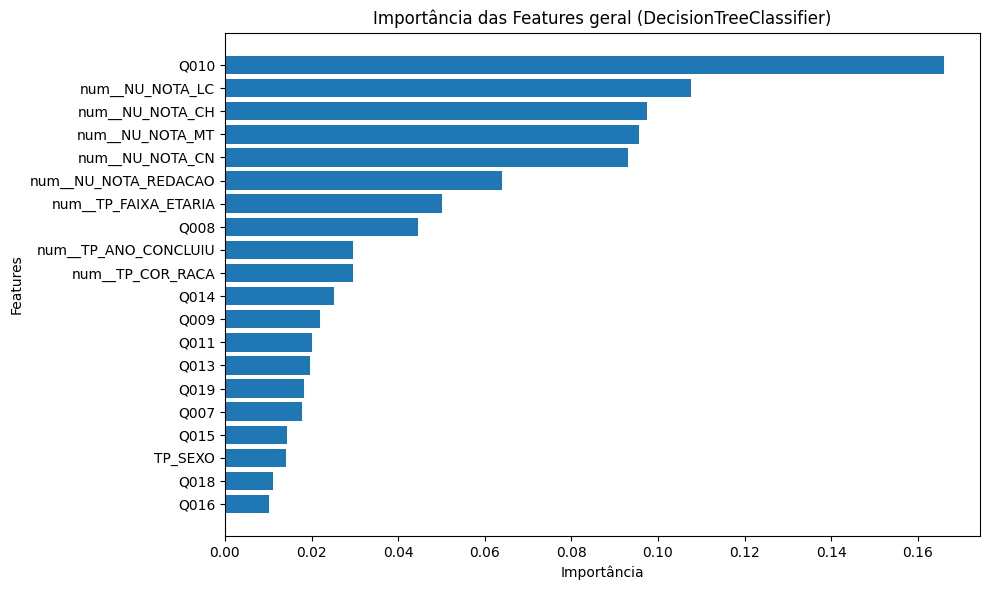

In [9]:
df_importancia = analisar_importancia_features_agregada(modelo, clf, "geral", 20)


Importância das features (sem agregação):
cat__Q010_A: 0.1596
num__NU_NOTA_LC: 0.1077
num__NU_NOTA_CH: 0.0974
num__NU_NOTA_MT: 0.0957
num__NU_NOTA_CN: 0.0932
num__NU_NOTA_REDACAO: 0.0639
num__TP_FAIXA_ETARIA: 0.0501
cat__Q008_B: 0.0359
num__TP_ANO_CONCLUIU: 0.0295
num__TP_COR_RACA: 0.0295
cat__Q014_A: 0.0223
cat__Q007_A: 0.0137
num__TP_ESCOLA: 0.0085
cat__Q011_A: 0.0084
cat__Q013_A: 0.0082


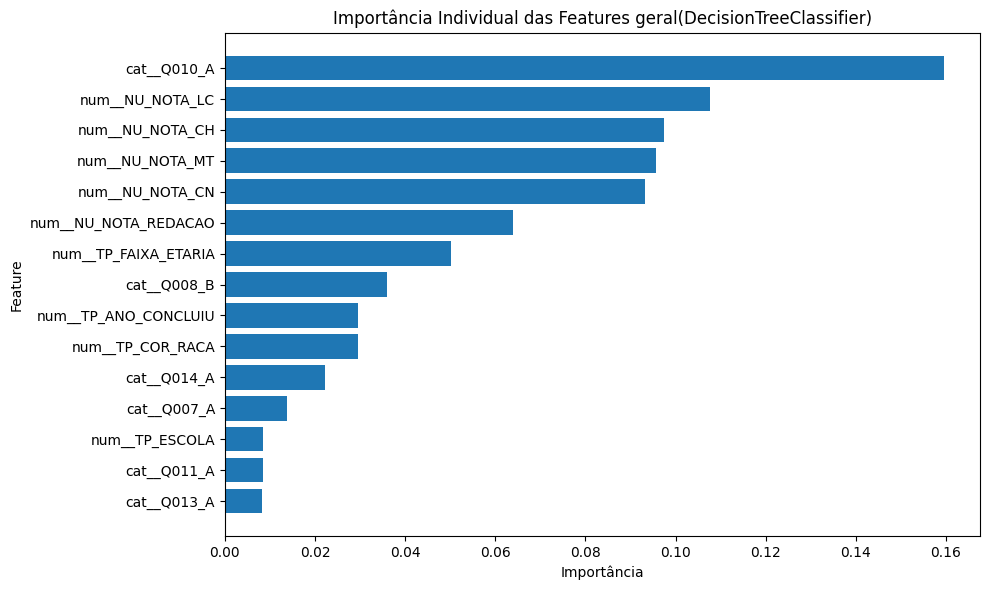

In [10]:
df_importancias_individuais = analisar_importancia_features(modelo, clf, "geral", top_n=15)



Resumo estatístico completo por classe social geral:
               classe_social      media    mediana  desvio_padrao   variancia         q1         q3  valor_minimo  valor_maximo  amplitude  coef_var
      Até 2 salários mínimos 508.083529 526.463908      59.625785 3555.234287 468.860000 526.463908          0.00        840.78     840.78 11.735430
   De 2 a 3 salários mínimos 530.199498 526.463908      63.806863 4071.315809 495.720000 559.720000          0.00        845.62     845.62 12.034501
   De 3 a 6 salários mínimos 557.275691 537.140000      74.766200 5589.984621 520.200000 604.260000          0.00        858.18     858.18 13.416376
  De 6 a 10 salários mínimos 598.258520 594.840000      82.425453 6793.955293 526.463908 661.185000         71.64        851.30     779.66 13.777564
 De 10 a 15 salários mínimos 616.689151 620.180000      83.286598 6936.657462 537.460000 682.060000        187.22        853.30     666.08 13.505442
Acima de 15 salários mínimos 626.069566 632.560000  

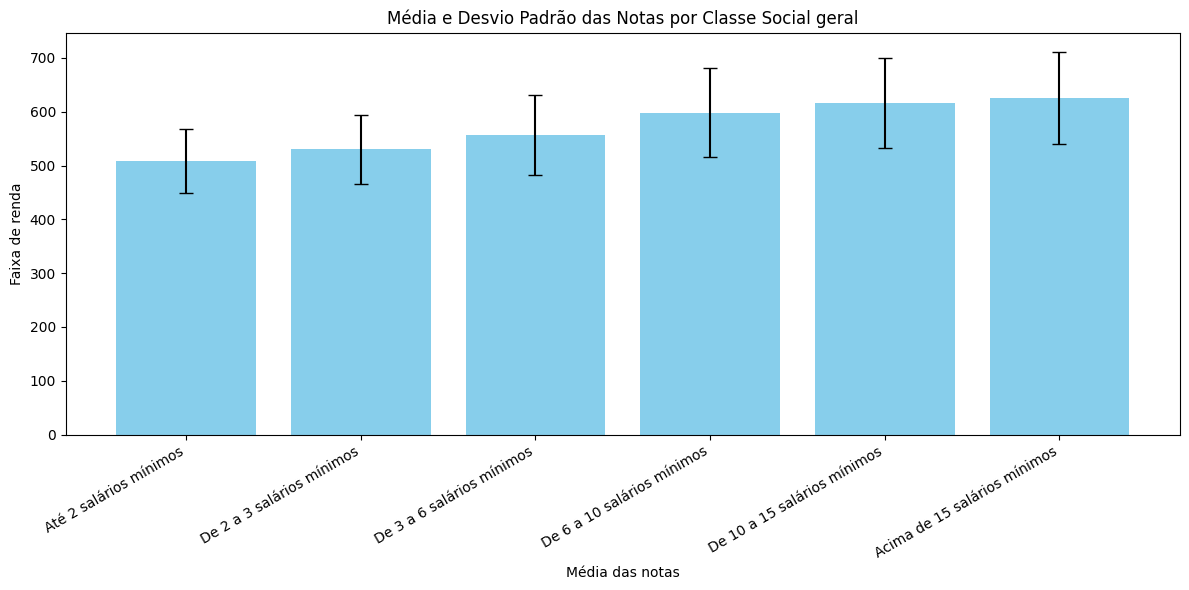

,classe_social,media,mediana,desvio_padrao,variancia,q1,q3,valor_minimo,valor_maximo,amplitude,coef_var,ordem
1,Até 2 salários mínimos,508.083529,526.463908,59.625785,3555.234287,468.860000,526.463908,0.00,840.78,840.78,11.735430,1
3,De 2 a 3 salários mínimos,530.199498,526.463908,63.806863,4071.315809,495.720000,559.720000,0.00,845.62,845.62,12.034501,2
4,De 3 a 6 salários mínimos,557.275691,537.140000,74.766200,5589.984621,520.200000,604.260000,0.00,858.18,858.18,13.416376,3
5,De 6 a 10 salários mínimos,598.258520,594.840000,82.425453,6793.955293,526.463908,661.185000,71.64,851.30,779.66,13.777564,4
2,De 10 a 15 salários mínimos,616.689151,620.180000,83.286598,6936.657462,537.460000,682.060000,187.22,853.30,666.08,13.505442,5
0,Acima de 15 salários mínimos,626.069566,632.560000,85.122355,7245.815366,545.030000,693.560000,138.58,853.22,714.64,13.596309,6


In [11]:
analisar_desempenho_por_classe(dataset_sem_nulos, "geral")

In [12]:
# Filtrar apenas homens
dataset_homem = dataset_sem_nulos[dataset_sem_nulos['TP_SEXO'] == "M"]

# Filtrar apenas mulheres
dataset_mulher = dataset_sem_nulos[dataset_sem_nulos['TP_SEXO'] == "F"]

In [13]:
modelo_homem, clf_homem = treinar_modelo(dataset_homem)

Acurácia: 0.9675993501873863

Relatório de classificação:
                               precision    recall  f1-score   support

Acima de 15 salários mínimos       0.99      1.00      0.99     29371
      Até 2 salários mínimos       0.96      0.99      0.98   1339326
 De 10 a 15 salários mínimos       0.99      0.98      0.99     44316
   De 2 a 3 salários mínimos       0.98      0.87      0.92    221070
   De 3 a 6 salários mínimos       0.98      0.94      0.96    513970
  De 6 a 10 salários mínimos       1.00      0.96      0.98    107982

                    accuracy                           0.97   2256035
                   macro avg       0.98      0.96      0.97   2256035
                weighted avg       0.97      0.97      0.97   2256035


Matriz de confusão:
 [[  29230      66       2       0      57      16]
 [     40 1332482       4     916    5831      53]
 [     73     311   43626      13     269      24]
 [     14   25467      49  192151    3362      27]
 [    113   

Importância das features (agregada):
Feature Q010: 0.1600
Feature num__NU_NOTA_MT: 0.1005
Feature num__NU_NOTA_LC: 0.0996
Feature num__NU_NOTA_CH: 0.0984
Feature num__NU_NOTA_CN: 0.0926
Feature num__NU_NOTA_REDACAO: 0.0651
Feature num__TP_FAIXA_ETARIA: 0.0544
Feature Q008: 0.0411
Feature num__TP_COR_RACA: 0.0329
Feature num__TP_ANO_CONCLUIU: 0.0327
Feature Q014: 0.0256
Feature Q009: 0.0246
Feature Q011: 0.0215
Feature Q013: 0.0207
Feature Q019: 0.0201
Feature Q007: 0.0192
Feature Q015: 0.0154
Feature Q018: 0.0119
Feature Q016: 0.0112
Feature Q012: 0.0100


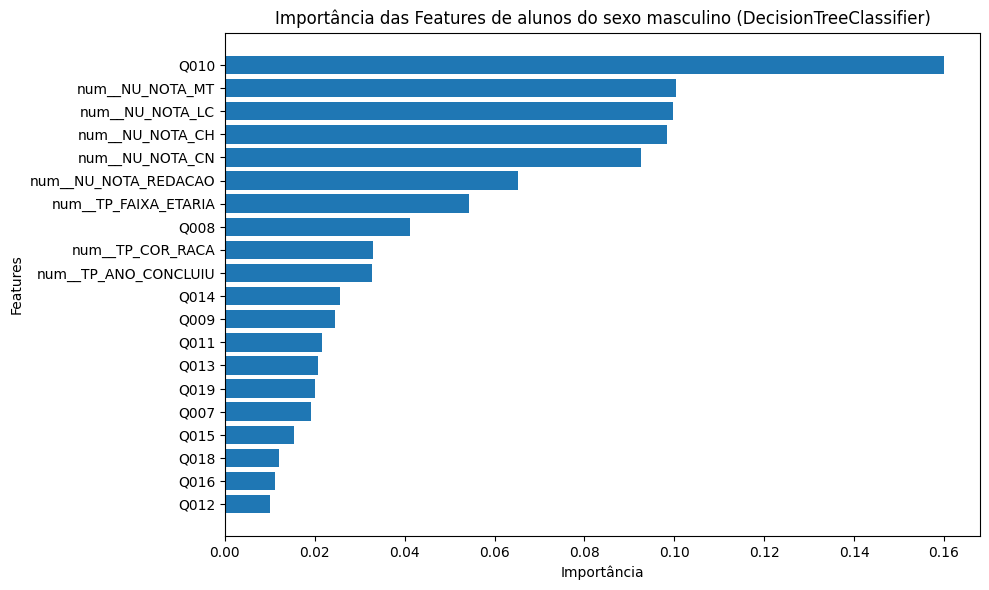

In [14]:
df_importancia_homem = analisar_importancia_features_agregada(modelo_homem, clf_homem, "de alunos do sexo masculino", 20)

Importância das features (sem agregação):
cat__Q010_A: 0.1532
num__NU_NOTA_MT: 0.1005
num__NU_NOTA_LC: 0.0996
num__NU_NOTA_CH: 0.0984
num__NU_NOTA_CN: 0.0926
num__NU_NOTA_REDACAO: 0.0651
num__TP_FAIXA_ETARIA: 0.0544
num__TP_COR_RACA: 0.0329
num__TP_ANO_CONCLUIU: 0.0327
cat__Q008_B: 0.0322
cat__Q014_A: 0.0221
cat__Q007_A: 0.0146
num__TP_ESCOLA: 0.0090
cat__Q011_A: 0.0090
cat__Q013_A: 0.0087


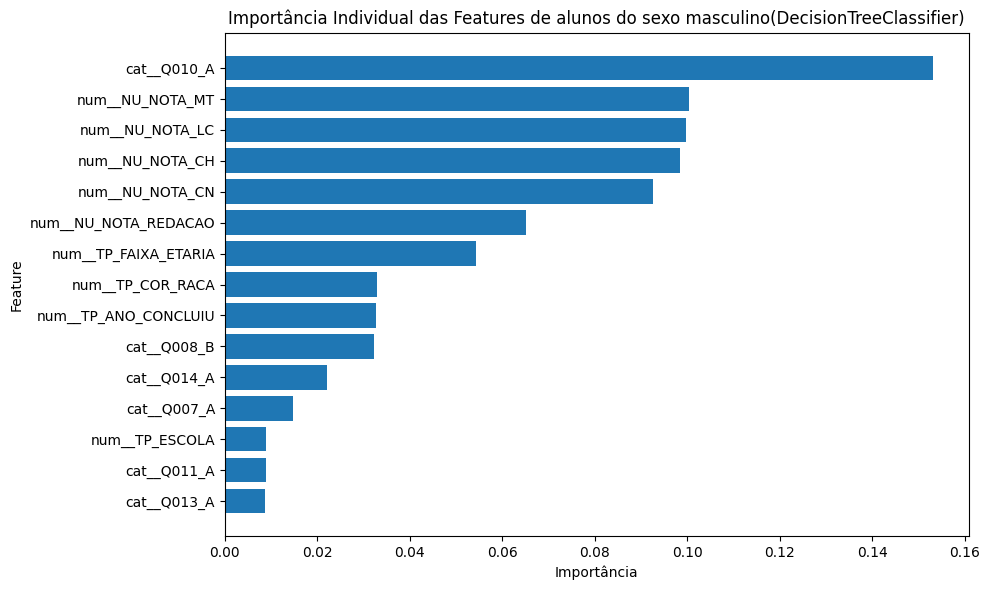

In [15]:
df_importancias_individuais_homem = analisar_importancia_features(modelo_homem, clf_homem, "de alunos do sexo masculino", top_n=15)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_11964\4091095090.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[notas].mean(axis=1)



Resumo estatístico completo por classe social de alunos do sexo masculino:
               classe_social      media    mediana  desvio_padrao   variancia         q1     q3  valor_minimo  valor_maximo  amplitude  coef_var
      Até 2 salários mínimos 512.145108 526.463908      62.042917 3849.323488 473.360000 532.06      0.000000        840.78 840.780000 12.114324
   De 2 a 3 salários mínimos 531.835100 526.463908      64.905310 4212.699309 498.520000 563.22     68.000000        845.62 777.620000 12.204029
   De 3 a 6 salários mínimos 556.145295 534.660000      74.383878 5532.961235 521.680000 602.86      0.000000        858.18 858.180000 13.374900
  De 6 a 10 salários mínimos 595.171550 590.800000      83.032841 6894.452676 526.463908 657.82     71.640000        851.30 779.660000 13.951077
 De 10 a 15 salários mínimos 615.040704 618.580000      84.577494 7153.352546 528.700000 681.26    205.817663        853.30 647.482337 13.751528
Acima de 15 salários mínimos 625.591442 632.060000    

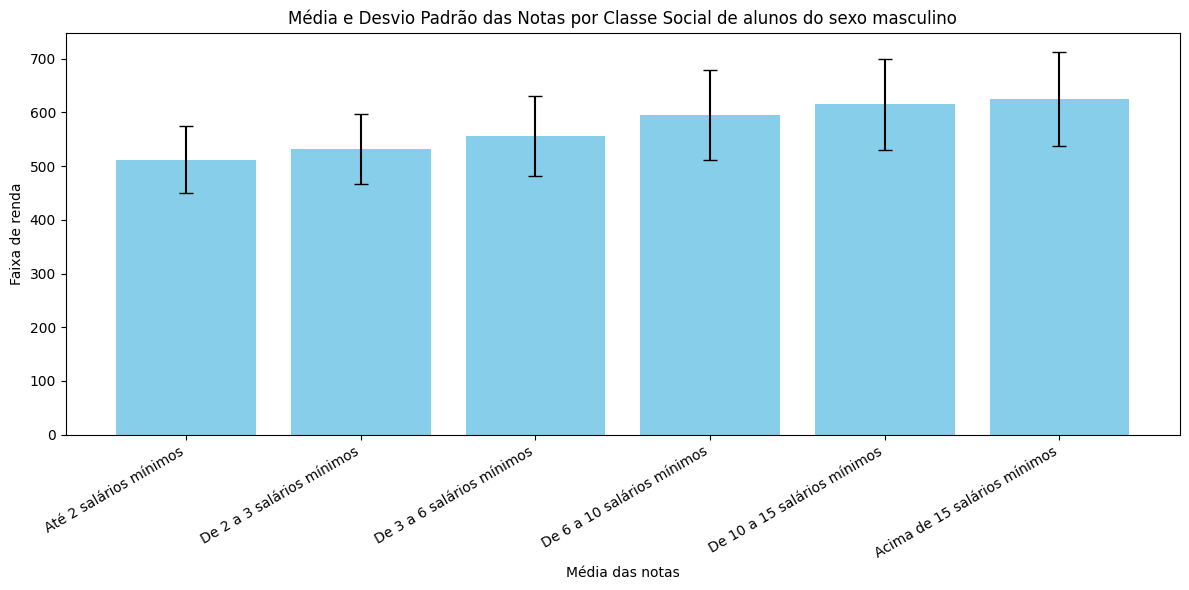

,classe_social,media,mediana,desvio_padrao,variancia,q1,q3,valor_minimo,valor_maximo,amplitude,coef_var,ordem
1,Até 2 salários mínimos,512.145108,526.463908,62.042917,3849.323488,473.360000,532.06,0.000000,840.78,840.780000,12.114324,1
3,De 2 a 3 salários mínimos,531.835100,526.463908,64.905310,4212.699309,498.520000,563.22,68.000000,845.62,777.620000,12.204029,2
4,De 3 a 6 salários mínimos,556.145295,534.660000,74.383878,5532.961235,521.680000,602.86,0.000000,858.18,858.180000,13.374900,3
5,De 6 a 10 salários mínimos,595.171550,590.800000,83.032841,6894.452676,526.463908,657.82,71.640000,851.30,779.660000,13.951077,4
2,De 10 a 15 salários mínimos,615.040704,618.580000,84.577494,7153.352546,528.700000,681.26,205.817663,853.30,647.482337,13.751528,5
0,Acima de 15 salários mínimos,625.591442,632.060000,87.125759,7590.897948,537.640000,694.51,138.580000,853.22,714.640000,13.926942,6


In [16]:
analisar_desempenho_por_classe(dataset_homem, "de alunos do sexo masculino")

In [17]:
modelo_mulher, clf_mulher = treinar_modelo(dataset_mulher)

Acurácia: 0.9720944053131997

Relatório de classificação:
                               precision    recall  f1-score   support

Acima de 15 salários mínimos       0.99      0.99      0.99     26392
      Até 2 salários mínimos       0.97      1.00      0.98   2207187
 De 10 a 15 salários mínimos       0.99      0.99      0.99     45533
   De 2 a 3 salários mínimos       0.98      0.86      0.92    288768
   De 3 a 6 salários mínimos       0.98      0.93      0.96    573248
  De 6 a 10 salários mínimos       1.00      0.97      0.98    116570

                    accuracy                           0.97   3257698
                   macro avg       0.98      0.96      0.97   3257698
                weighted avg       0.97      0.97      0.97   3257698


Matriz de confusão:
 [[  26252      69       7       5      47      12]
 [     23 2200905       6    1122    5093      38]
 [    109     314   44866      19     203      22]
 [     13   38250      44  247512    2926      23]
 [     77   

Importância das features (agregada):
Feature Q010: 0.1676
Feature num__NU_NOTA_LC: 0.1146
Feature num__NU_NOTA_CH: 0.0997
Feature num__NU_NOTA_MT: 0.0973
Feature num__NU_NOTA_CN: 0.0950
Feature num__NU_NOTA_REDACAO: 0.0643
Feature num__TP_FAIXA_ETARIA: 0.0488
Feature Q008: 0.0475
Feature num__TP_ANO_CONCLUIU: 0.0294
Feature num__TP_COR_RACA: 0.0290
Feature Q014: 0.0247
Feature Q009: 0.0219
Feature Q011: 0.0197
Feature Q013: 0.0193
Feature Q019: 0.0182


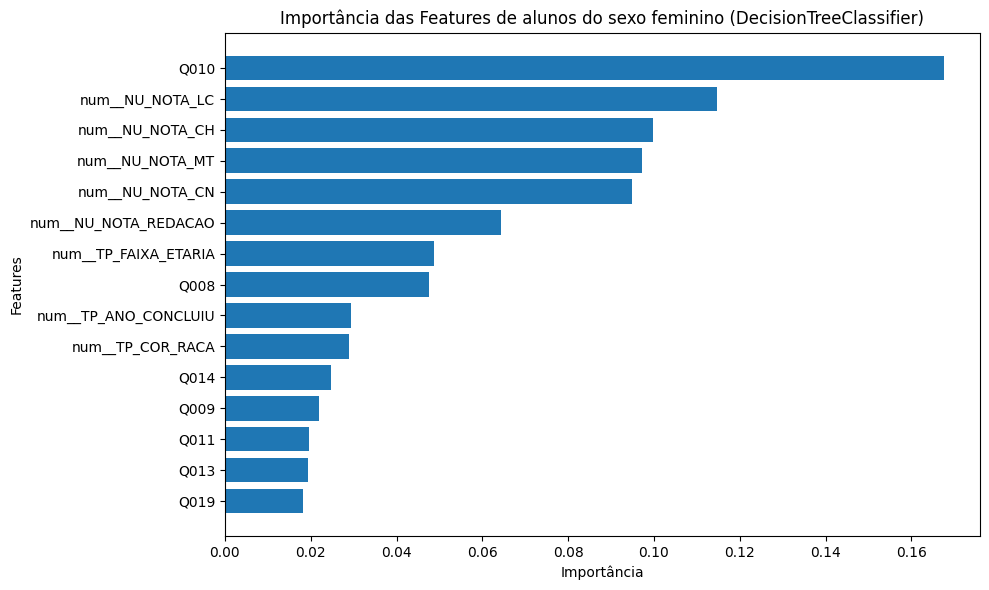

In [18]:
df_importancias_mulher = analisar_importancia_features_agregada(modelo_mulher,clf_mulher, "de alunos do sexo feminino", top_n=15)

Importância das features (sem agregação):
cat__Q010_A: 0.1613
num__NU_NOTA_LC: 0.1146
num__NU_NOTA_CH: 0.0997
num__NU_NOTA_MT: 0.0973
num__NU_NOTA_CN: 0.0950
num__NU_NOTA_REDACAO: 0.0643
num__TP_FAIXA_ETARIA: 0.0488
cat__Q008_B: 0.0391
num__TP_ANO_CONCLUIU: 0.0294
num__TP_COR_RACA: 0.0290
cat__Q014_A: 0.0221
cat__Q007_A: 0.0131
num__TP_ESCOLA: 0.0092
num__TP_ST_CONCLUSAO: 0.0088
num__TP_ESTADO_CIVIL: 0.0085


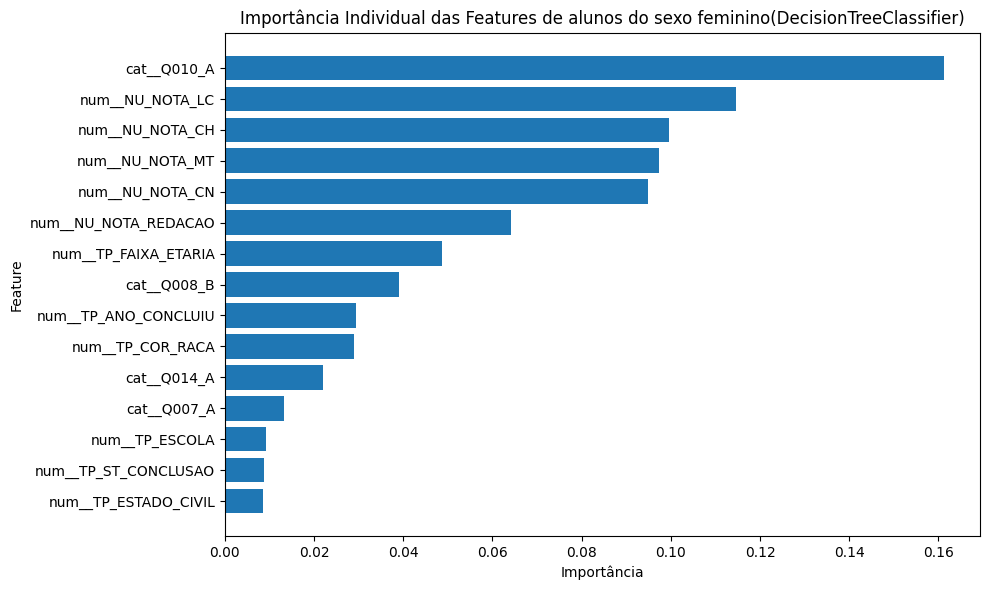

In [19]:
df_importancias_individuais_mulher = analisar_importancia_features(modelo_mulher, clf_mulher, "de alunos do sexo feminino", top_n=15)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_11964\4091095090.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[notas].mean(axis=1)



Resumo estatístico completo por classe social de alunos do sexo feminino:
               classe_social      media    mediana  desvio_padrao   variancia         q1         q3  valor_minimo  valor_maximo  amplitude  coef_var
      Até 2 salários mínimos 505.618955 525.500000      57.971525 3360.697767 466.480000 526.463908      0.000000        811.62 811.620000 11.465457
   De 2 a 3 salários mínimos 528.947342 526.463908      62.924369 3959.476158 493.840000 557.060000      0.000000        816.92 816.920000 11.896150
   De 3 a 6 salários mínimos 558.289197 539.180000      75.092931 5638.948255 518.980000 605.600000     72.500000        838.22 765.720000 13.450543
  De 6 a 10 salários mínimos 601.118065 598.480000      81.755218 6683.915676 526.463908 664.320000    177.760000        846.92 669.160000 13.600526
 De 10 a 15 salários mínimos 618.293539 621.660000      81.979801 6720.687725 544.640000 682.860000    187.220000        852.58 665.360000 13.259042
Acima de 15 salários mínimos 62

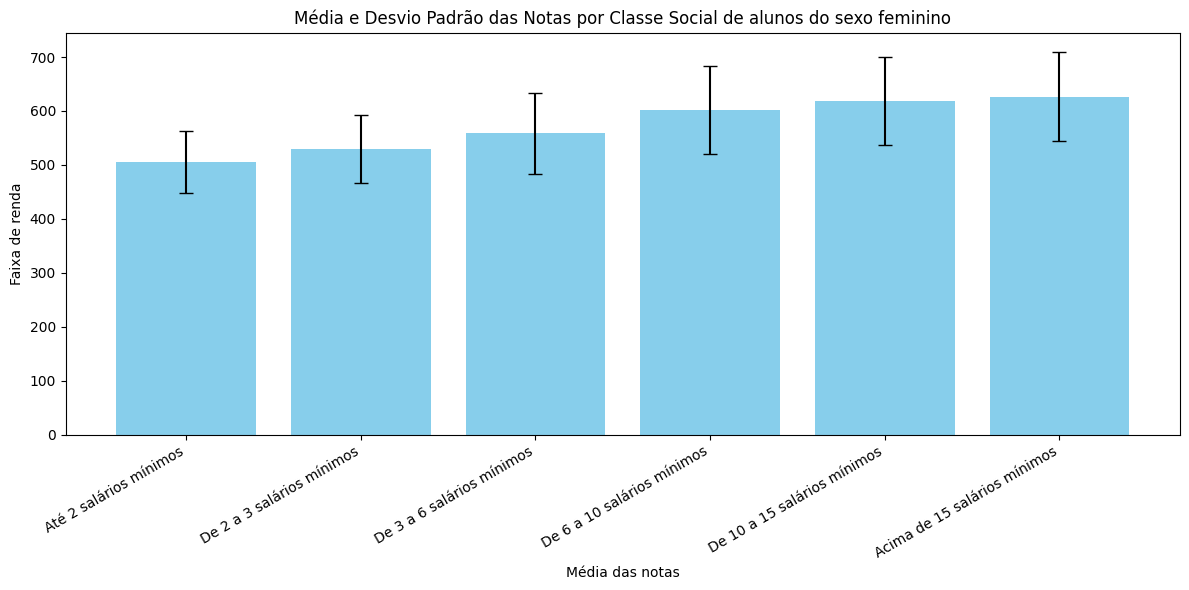

,classe_social,media,mediana,desvio_padrao,variancia,q1,q3,valor_minimo,valor_maximo,amplitude,coef_var,ordem
1,Até 2 salários mínimos,505.618955,525.500000,57.971525,3360.697767,466.480000,526.463908,0.000000,811.62,811.620000,11.465457,1
3,De 2 a 3 salários mínimos,528.947342,526.463908,62.924369,3959.476158,493.840000,557.060000,0.000000,816.92,816.920000,11.896150,2
4,De 3 a 6 salários mínimos,558.289197,539.180000,75.092931,5638.948255,518.980000,605.600000,72.500000,838.22,765.720000,13.450543,3
5,De 6 a 10 salários mínimos,601.118065,598.480000,81.755218,6683.915676,526.463908,664.320000,177.760000,846.92,669.160000,13.600526,4
2,De 10 a 15 salários mínimos,618.293539,621.660000,81.979801,6720.687725,544.640000,682.860000,187.220000,852.58,665.360000,13.259042,5
0,Acima de 15 salários mínimos,626.601658,633.210000,82.834275,6861.517081,551.360000,692.440000,205.817663,848.90,643.082337,13.219607,6


In [20]:
analisar_desempenho_por_classe(dataset_mulher, "de alunos do sexo feminino")

In [21]:
# Filtrar apenas escolas urbanas
dataset_urbano = dataset_sem_nulos[dataset_sem_nulos['TP_LOCALIZACAO_ESC'] == 1]

# Filtrar apenas escolas rurais
dataset_rural = dataset_sem_nulos[dataset_sem_nulos['TP_LOCALIZACAO_ESC'] == 2]

In [22]:
modelo_urbano, clf_urbano = treinar_modelo(dataset_urbano)

Acurácia: 0.970017250018392

Relatório de classificação:
                               precision    recall  f1-score   support

Acima de 15 salários mínimos       0.99      0.99      0.99     55701
      Até 2 salários mínimos       0.96      1.00      0.98   3505804
 De 10 a 15 salários mínimos       0.99      0.98      0.99     89700
   De 2 a 3 salários mínimos       0.98      0.86      0.92    506886
   De 3 a 6 salários mínimos       0.98      0.93      0.96   1082282
  De 6 a 10 salários mínimos       1.00      0.96      0.98    223969

                    accuracy                           0.97   5464342
                   macro avg       0.98      0.96      0.97   5464342
                weighted avg       0.97      0.97      0.97   5464342


Matriz de confusão:
 [[  55420     135       9       5     104      28]
 [     63 3492680      10    2038   10922      91]
 [    182     625   88343      32     472      46]
 [     27   63608      93  436822    6286      50]
 [    190   6

Importância das features (agregada):
Feature Q010: 0.1660
Feature num__NU_NOTA_LC: 0.1078
Feature num__NU_NOTA_CH: 0.0975
Feature num__NU_NOTA_MT: 0.0964
Feature num__NU_NOTA_CN: 0.0927
Feature num__NU_NOTA_REDACAO: 0.0639
Feature num__TP_FAIXA_ETARIA: 0.0503
Feature Q008: 0.0443
Feature num__TP_COR_RACA: 0.0298
Feature num__TP_ANO_CONCLUIU: 0.0297
Feature Q014: 0.0253
Feature Q009: 0.0217
Feature Q011: 0.0202
Feature Q013: 0.0200
Feature Q019: 0.0181
Feature Q007: 0.0177
Feature Q015: 0.0145
Feature TP_SEXO: 0.0140
Feature Q018: 0.0112
Feature Q016: 0.0103


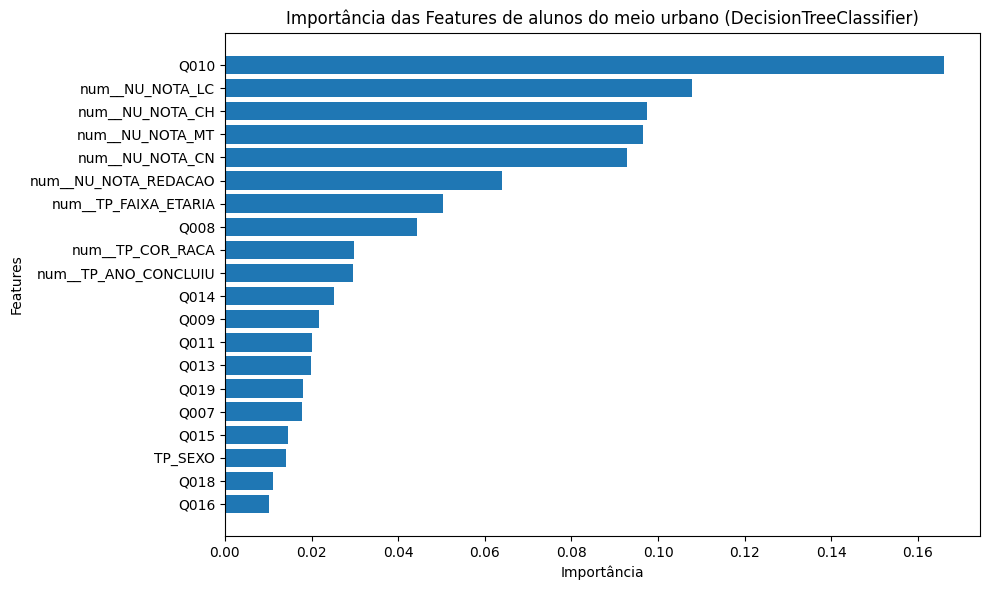

In [23]:
df_importancia_urbano = analisar_importancia_features_agregada(modelo_urbano, clf_urbano, "de alunos do meio urbano", 20)

Importância das features (sem agregação):
cat__Q010_A: 0.1595
num__NU_NOTA_LC: 0.1078
num__NU_NOTA_CH: 0.0975
num__NU_NOTA_MT: 0.0964
num__NU_NOTA_CN: 0.0927
num__NU_NOTA_REDACAO: 0.0639
num__TP_FAIXA_ETARIA: 0.0503
cat__Q008_B: 0.0358
num__TP_COR_RACA: 0.0298
num__TP_ANO_CONCLUIU: 0.0297
cat__Q014_A: 0.0222
cat__Q007_A: 0.0138
num__TP_ESCOLA: 0.0086
cat__Q011_A: 0.0084
cat__Q013_A: 0.0083


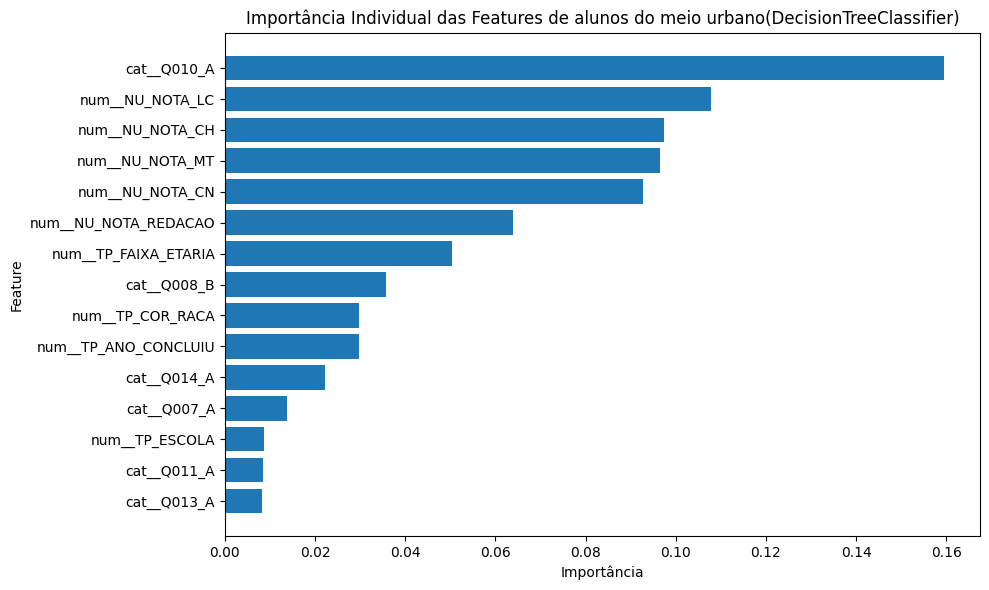

In [24]:
df_importancias_individuais_urbano = analisar_importancia_features(modelo_urbano, clf_urbano, "de alunos do meio urbano", top_n=15)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_11964\4091095090.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[notas].mean(axis=1)



Resumo estatístico completo por classe social de alunos do meio urbano:
               classe_social      media    mediana  desvio_padrao   variancia         q1         q3  valor_minimo  valor_maximo  amplitude  coef_var
      Até 2 salários mínimos 508.251464 526.463908      59.570550 3548.650437 469.120000 526.463908          0.00        840.78     840.78 11.720684
   De 2 a 3 salários mínimos 530.224125 526.463908      63.767290 4066.267255 495.840000 559.680000          0.00        845.62     845.62 12.026478
   De 3 a 6 salários mínimos 557.308850 537.120000      74.768126 5590.272613 520.280000 604.280000          0.00        858.18     858.18 13.415923
  De 6 a 10 salários mínimos 598.300508 594.860000      82.429349 6794.597499 526.463908 661.240000         71.64        851.30     779.66 13.777249
 De 10 a 15 salários mínimos 616.728338 620.220000      83.301756 6939.182620 537.460000 682.120000        187.22        853.30     666.08 13.507042
Acima de 15 salários mínimos 626.

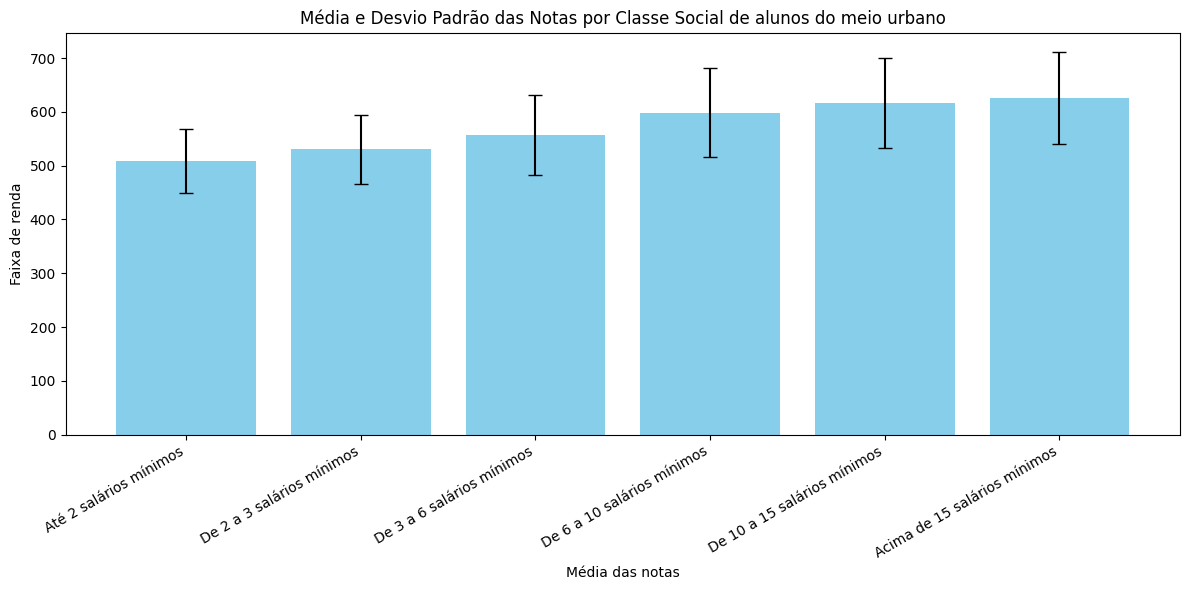

,classe_social,media,mediana,desvio_padrao,variancia,q1,q3,valor_minimo,valor_maximo,amplitude,coef_var,ordem
1,Até 2 salários mínimos,508.251464,526.463908,59.570550,3548.650437,469.120000,526.463908,0.00,840.78,840.78,11.720684,1
3,De 2 a 3 salários mínimos,530.224125,526.463908,63.767290,4066.267255,495.840000,559.680000,0.00,845.62,845.62,12.026478,2
4,De 3 a 6 salários mínimos,557.308850,537.120000,74.768126,5590.272613,520.280000,604.280000,0.00,858.18,858.18,13.415923,3
5,De 6 a 10 salários mínimos,598.300508,594.860000,82.429349,6794.597499,526.463908,661.240000,71.64,851.30,779.66,13.777249,4
2,De 10 a 15 salários mínimos,616.728338,620.220000,83.301756,6939.182620,537.460000,682.120000,187.22,853.30,666.08,13.507042,5
0,Acima de 15 salários mínimos,626.107365,632.640000,85.127717,7246.728126,545.040000,693.600000,138.58,853.22,714.64,13.596345,6


In [25]:
analisar_desempenho_por_classe(dataset_urbano, "de alunos do meio urbano")

In [26]:
# Filtrar apenas homens do meio urbano
dataset_urbano_homem = dataset_urbano[dataset_urbano['TP_SEXO'] == "M"]

# Filtrar apenas mulheres do meio urbano
dataset_urbano_mulher = dataset_urbano[dataset_urbano['TP_SEXO'] == "F"]

In [27]:
modelo_urbano_homem, clf_urbano_homem = treinar_modelo(dataset_urbano_homem)

Acurácia: 0.9673230959545033

Relatório de classificação:
                               precision    recall  f1-score   support

Acima de 15 salários mínimos       0.99      1.00      0.99     29325
      Até 2 salários mínimos       0.96      0.99      0.98   1322226
 De 10 a 15 salários mínimos       0.99      0.98      0.99     44242
   De 2 a 3 salários mínimos       0.98      0.87      0.92    219600
   De 3 a 6 salários mínimos       0.98      0.94      0.96    511319
  De 6 a 10 salários mínimos       1.00      0.96      0.98    107649

                    accuracy                           0.97   2234361
                   macro avg       0.98      0.96      0.97   2234361
                weighted avg       0.97      0.97      0.97   2234361


Matriz de confusão:
 [[  29184      66       2       0      57      16]
 [     40 1315384       4     916    5829      53]
 [     73     311   43552      13     269      24]
 [     14   25419      49  190731    3360      27]
 [    113   

Importância das features (agregada):
Feature Q010: 0.1598
Feature num__NU_NOTA_MT: 0.1002
Feature num__NU_NOTA_LC: 0.0999
Feature num__NU_NOTA_CH: 0.0981
Feature num__NU_NOTA_CN: 0.0932
Feature num__NU_NOTA_REDACAO: 0.0652
Feature num__TP_FAIXA_ETARIA: 0.0549
Feature Q008: 0.0410
Feature num__TP_ANO_CONCLUIU: 0.0330
Feature num__TP_COR_RACA: 0.0326
Feature Q014: 0.0255
Feature Q009: 0.0244
Feature Q011: 0.0219
Feature Q013: 0.0205
Feature Q019: 0.0203
Feature Q007: 0.0192
Feature Q015: 0.0155
Feature Q018: 0.0119
Feature Q016: 0.0111
Feature Q012: 0.0102


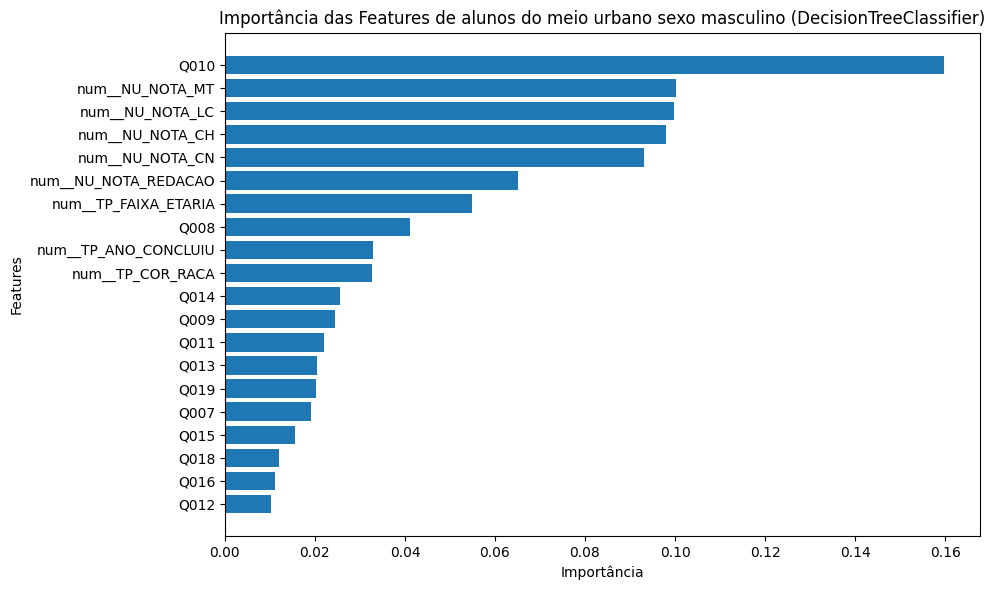

In [28]:
df_importancia_urbano_homem = analisar_importancia_features_agregada(modelo_urbano_homem, clf_urbano_homem, "de alunos do meio urbano sexo masculino", 20)

Importância das features (sem agregação):
cat__Q010_A: 0.1530
num__NU_NOTA_MT: 0.1002
num__NU_NOTA_LC: 0.0999
num__NU_NOTA_CH: 0.0981
num__NU_NOTA_CN: 0.0932
num__NU_NOTA_REDACAO: 0.0652
num__TP_FAIXA_ETARIA: 0.0549
num__TP_ANO_CONCLUIU: 0.0330
num__TP_COR_RACA: 0.0326
cat__Q008_B: 0.0322
cat__Q014_A: 0.0220
cat__Q007_A: 0.0147
num__TP_ESCOLA: 0.0091
cat__Q011_A: 0.0091
num__TP_ST_CONCLUSAO: 0.0091


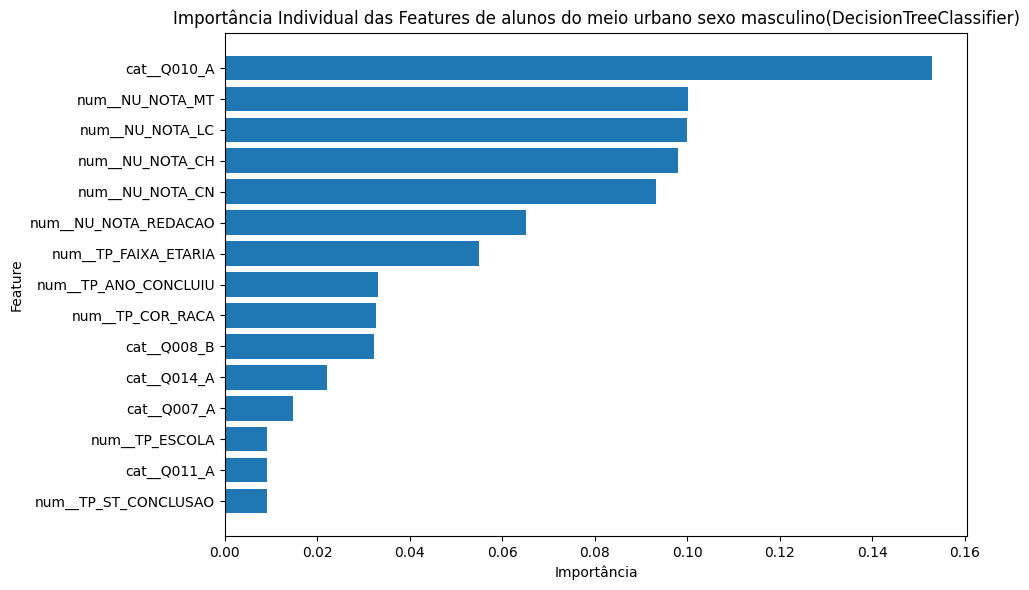

In [29]:
df_importancias_individuais_urbano_homem = analisar_importancia_features(modelo_urbano_homem, clf_urbano_homem, "de alunos do meio urbano sexo masculino", top_n=15)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_11964\4091095090.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[notas].mean(axis=1)



Resumo estatístico completo por classe social de alunos do meio urbano sexo masculino:
               classe_social      media    mediana  desvio_padrao   variancia         q1     q3  valor_minimo  valor_maximo  amplitude  coef_var
      Até 2 salários mínimos 512.369033 526.463908      61.969187 3840.180193 473.720000 532.38      0.000000        840.78 840.780000 12.094639
   De 2 a 3 salários mínimos 531.886890 526.463908      64.834197 4203.473091 498.700000 563.18     68.000000        845.62 777.620000 12.189471
   De 3 a 6 salários mínimos 556.189735 534.660000      74.375166 5531.665381 521.800000 602.88      0.000000        858.18 858.180000 13.372265
  De 6 a 10 salários mínimos 595.219224 590.840000      83.038096 6895.325335 526.463908 657.88     71.640000        851.30 779.660000 13.950842
 De 10 a 15 salários mínimos 615.073006 618.630000      84.596043 7156.490500 528.660000 681.30    205.817663        853.30 647.482337 13.753821
Acima de 15 salários mínimos 625.657266 63

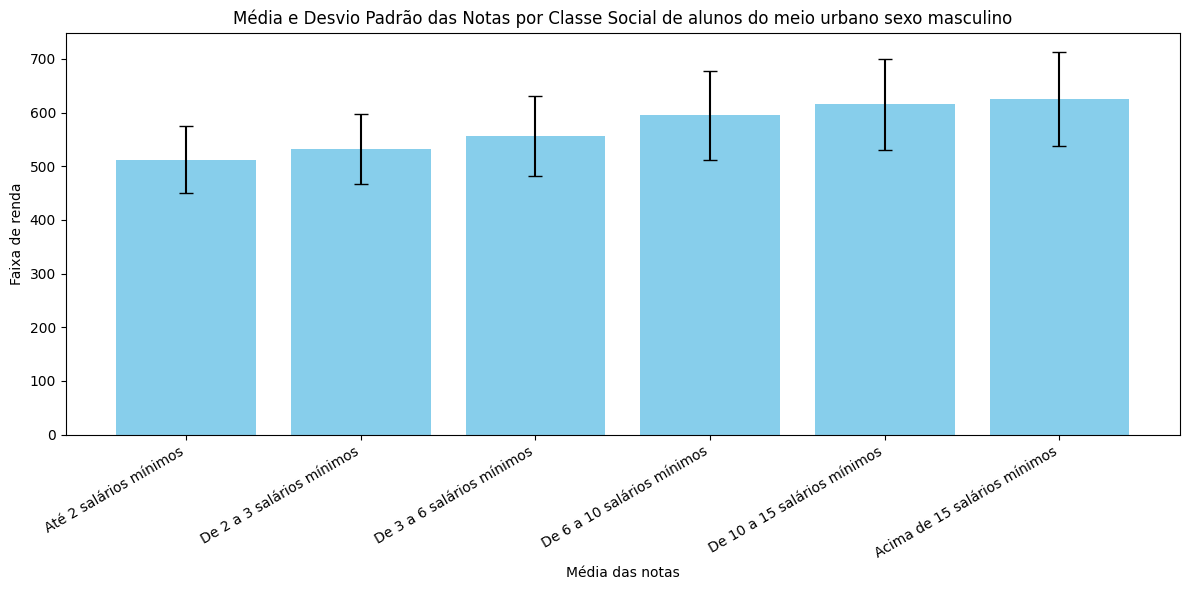

,classe_social,media,mediana,desvio_padrao,variancia,q1,q3,valor_minimo,valor_maximo,amplitude,coef_var,ordem
1,Até 2 salários mínimos,512.369033,526.463908,61.969187,3840.180193,473.720000,532.38,0.000000,840.78,840.780000,12.094639,1
3,De 2 a 3 salários mínimos,531.886890,526.463908,64.834197,4203.473091,498.700000,563.18,68.000000,845.62,777.620000,12.189471,2
4,De 3 a 6 salários mínimos,556.189735,534.660000,74.375166,5531.665381,521.800000,602.88,0.000000,858.18,858.180000,13.372265,3
5,De 6 a 10 salários mínimos,595.219224,590.840000,83.038096,6895.325335,526.463908,657.88,71.640000,851.30,779.660000,13.950842,4
2,De 10 a 15 salários mínimos,615.073006,618.630000,84.596043,7156.490500,528.660000,681.30,205.817663,853.30,647.482337,13.753821,5
0,Acima de 15 salários mínimos,625.657266,632.240000,87.135238,7592.549653,537.700000,694.56,138.580000,853.22,714.640000,13.926992,6


In [30]:
analisar_desempenho_por_classe(dataset_urbano_homem, "de alunos do meio urbano sexo masculino")

In [31]:
modelo_urbano_mulher, clf_urbano_mulher = treinar_modelo(dataset_urbano_mulher)

Acurácia: 0.9718809491449021

Relatório de classificação:
                               precision    recall  f1-score   support

Acima de 15 salários mínimos       0.99      0.99      0.99     26376
      Até 2 salários mínimos       0.97      1.00      0.98   2183578
 De 10 a 15 salários mínimos       0.99      0.99      0.99     45458
   De 2 a 3 salários mínimos       0.98      0.86      0.92    287286
   De 3 a 6 salários mínimos       0.98      0.93      0.96    570963
  De 6 a 10 salários mínimos       1.00      0.96      0.98    116320

                    accuracy                           0.97   3229981
                   macro avg       0.98      0.96      0.97   3229981
                weighted avg       0.97      0.97      0.97   3229981


Matriz de confusão:
 [[  26236      69       7       5      47      12]
 [     23 2177296       6    1122    5093      38]
 [    109     314   44791      19     203      22]
 [     13   38189      44  246091    2926      23]
 [     77   

Importância das features (agregada):
Feature Q010: 0.1678
Feature num__NU_NOTA_LC: 0.1149
Feature num__NU_NOTA_CH: 0.0992
Feature num__NU_NOTA_MT: 0.0978
Feature num__NU_NOTA_CN: 0.0952
Feature num__NU_NOTA_REDACAO: 0.0638
Feature num__TP_FAIXA_ETARIA: 0.0495
Feature Q008: 0.0474
Feature num__TP_ANO_CONCLUIU: 0.0293
Feature num__TP_COR_RACA: 0.0288
Feature Q014: 0.0246
Feature Q009: 0.0218
Feature Q011: 0.0197
Feature Q013: 0.0195
Feature Q019: 0.0184
Feature Q007: 0.0171
Feature Q015: 0.0144
Feature Q018: 0.0111
Feature Q016: 0.0105
Feature num__TP_ESCOLA: 0.0094


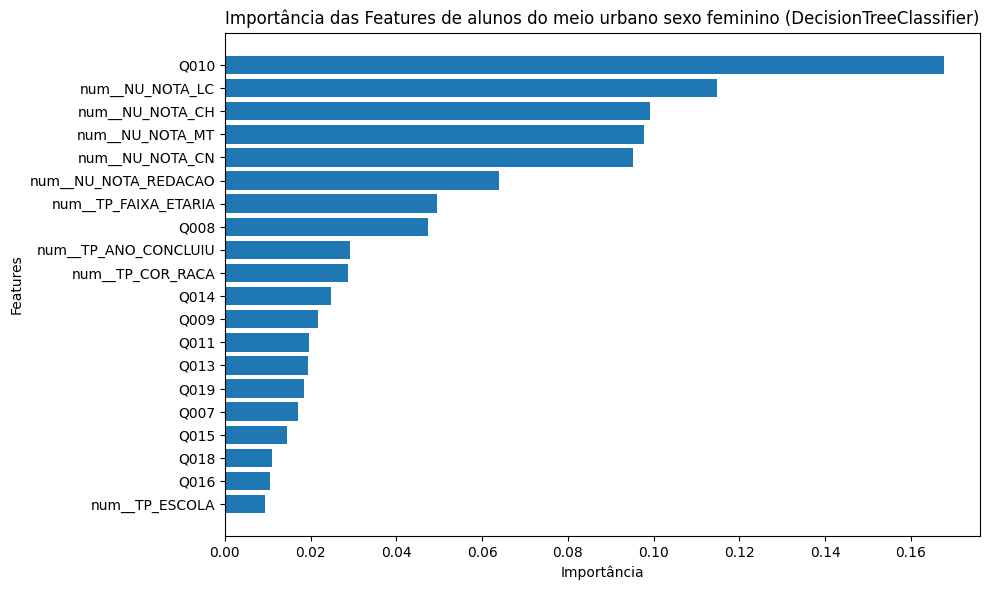

In [32]:
df_importancia_urbano_mulher = analisar_importancia_features_agregada(modelo_urbano_mulher, clf_urbano_mulher, "de alunos do meio urbano sexo feminino", 20)

Importância das features (sem agregação):
cat__Q010_A: 0.1613
num__NU_NOTA_LC: 0.1149
num__NU_NOTA_CH: 0.0992
num__NU_NOTA_MT: 0.0978
num__NU_NOTA_CN: 0.0952
num__NU_NOTA_REDACAO: 0.0638
num__TP_FAIXA_ETARIA: 0.0495
cat__Q008_B: 0.0390
num__TP_ANO_CONCLUIU: 0.0293
num__TP_COR_RACA: 0.0288
cat__Q014_A: 0.0219
cat__Q007_A: 0.0132
num__TP_ESCOLA: 0.0094
num__TP_ST_CONCLUSAO: 0.0087
num__TP_ESTADO_CIVIL: 0.0085


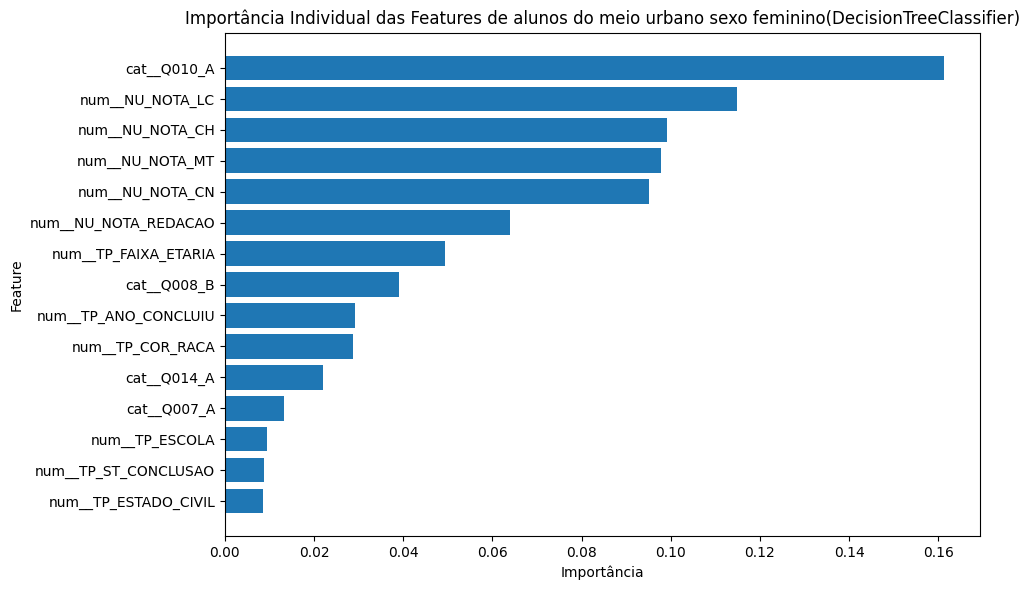

In [33]:
df_importancias_individuais_urbano_mulher = analisar_importancia_features(modelo_urbano_mulher, clf_urbano_mulher, "de alunos do meio urbano sexo feminino", top_n=15)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_11964\4091095090.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[notas].mean(axis=1)



Resumo estatístico completo por classe social de alunos do meio urbano sexo feminino:
               classe_social      media    mediana  desvio_padrao   variancia         q1         q3  valor_minimo  valor_maximo  amplitude  coef_var
      Até 2 salários mínimos 505.758145 525.740000      57.927873 3355.638503 466.700000 526.463908      0.000000        811.62 811.620000 11.453671
   De 2 a 3 salários mínimos 528.953115 526.463908      62.910040 3957.673190 493.884416 557.000000      0.000000        816.92 816.920000 11.893311
   De 3 a 6 salários mínimos 558.311059 539.140000      75.104203 5640.641375 519.031954 605.600000     72.500000        838.22 765.720000 13.452036
  De 6 a 10 salários mínimos 601.152100 598.520000      81.758905 6684.518544 526.463908 664.360000    177.760000        846.92 669.160000 13.600369
 De 10 a 15 salários mínimos 618.339390 621.700000      81.991329 6722.578069 544.680000 682.880000    187.220000        852.58 665.360000 13.259923
Acima de 15 salário

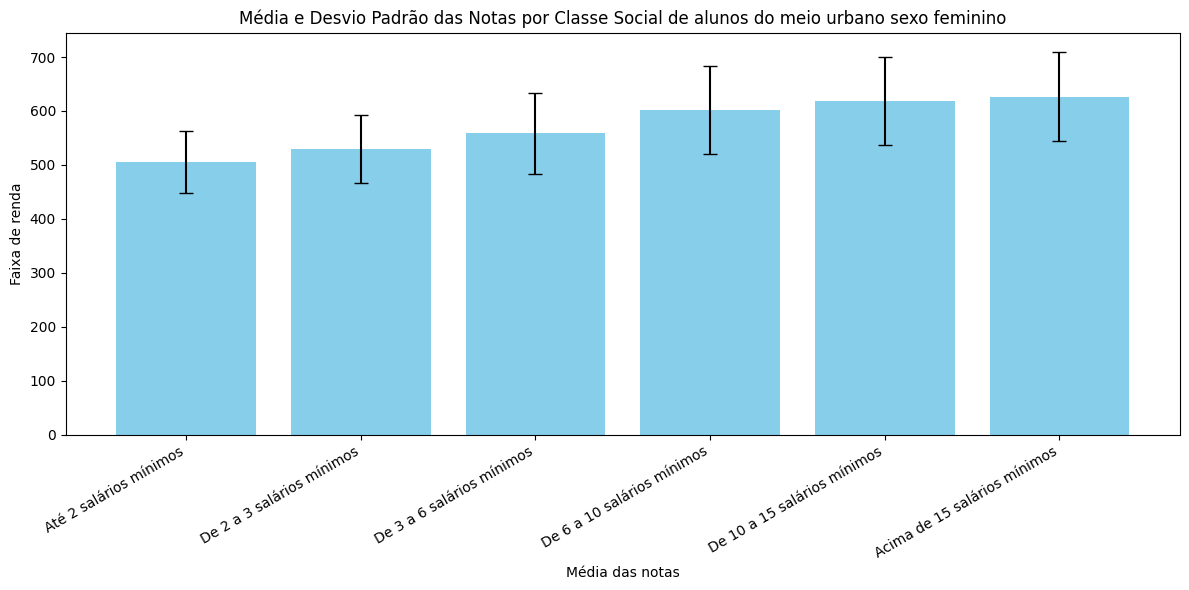

,classe_social,media,mediana,desvio_padrao,variancia,q1,q3,valor_minimo,valor_maximo,amplitude,coef_var,ordem
1,Até 2 salários mínimos,505.758145,525.740000,57.927873,3355.638503,466.700000,526.463908,0.000000,811.62,811.620000,11.453671,1
3,De 2 a 3 salários mínimos,528.953115,526.463908,62.910040,3957.673190,493.884416,557.000000,0.000000,816.92,816.920000,11.893311,2
4,De 3 a 6 salários mínimos,558.311059,539.140000,75.104203,5640.641375,519.031954,605.600000,72.500000,838.22,765.720000,13.452036,3
5,De 6 a 10 salários mínimos,601.152100,598.520000,81.758905,6684.518544,526.463908,664.360000,177.760000,846.92,669.160000,13.600369,4
2,De 10 a 15 salários mínimos,618.339390,621.700000,81.991329,6722.578069,544.680000,682.880000,187.220000,852.58,665.360000,13.259923,5
0,Acima de 15 salários mínimos,626.607787,633.230000,82.837426,6862.039223,551.360000,692.440000,205.817663,848.90,643.082337,13.219980,6


In [34]:
analisar_desempenho_por_classe(dataset_urbano_mulher, "de alunos do meio urbano sexo feminino")

In [35]:
modelo_rural, clf_rural = treinar_modelo(dataset_rural)

Acurácia: 0.9965783239861513

Relatório de classificação:
                               precision    recall  f1-score   support

Acima de 15 salários mínimos       1.00      1.00      1.00        62
      Até 2 salários mínimos       1.00      1.00      1.00     40709
 De 10 a 15 salários mínimos       1.00      1.00      1.00       149
   De 2 a 3 salários mínimos       1.00      0.96      0.98      2952
   De 3 a 6 salários mínimos       1.00      0.99      0.99      4936
  De 6 a 10 salários mínimos       1.00      0.99      1.00       583

                    accuracy                           1.00     49391
                   macro avg       1.00      0.99      0.99     49391
                weighted avg       1.00      1.00      1.00     49391


Matriz de confusão:
 [[   62     0     0     0     0     0]
 [    0 40707     0     0     2     0]
 [    0     0   149     0     0     0]
 [    0   109     0  2841     2     0]
 [    0    47     0     6  4883     0]
 [    0     3     0  

Importância das features (agregada):
Feature Q010: 0.1566
Feature num__NU_NOTA_LC: 0.1107
Feature num__NU_NOTA_MT: 0.1030
Feature num__NU_NOTA_CH: 0.0927
Feature num__NU_NOTA_CN: 0.0915
Feature num__NU_NOTA_REDACAO: 0.0658
Feature Q008: 0.0484
Feature Q009: 0.0360
Feature num__TP_FAIXA_ETARIA: 0.0340
Feature Q014: 0.0292
Feature Q011: 0.0282
Feature num__TP_COR_RACA: 0.0277
Feature Q013: 0.0263
Feature Q019: 0.0249
Feature num__TP_ESCOLA: 0.0232
Feature TP_SEXO: 0.0230
Feature Q015: 0.0152
Feature Q016: 0.0139
Feature Q018: 0.0128
Feature Q012: 0.0110


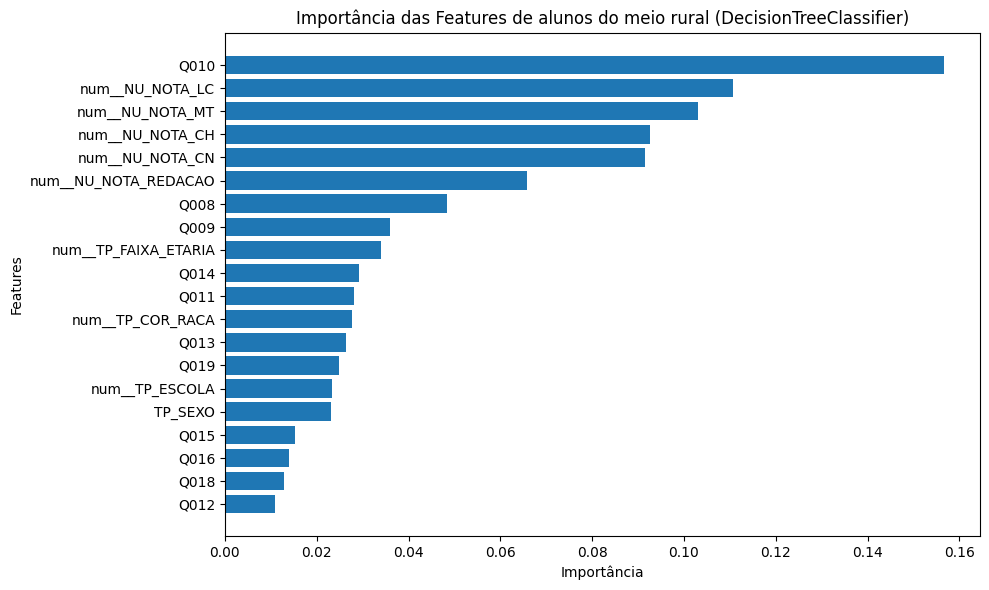

In [36]:
df_importancia_rural = analisar_importancia_features_agregada(modelo_rural,clf_rural, "de alunos do meio rural", top_n=20)

Importância das features (sem agregação):
cat__Q010_A: 0.1452
num__NU_NOTA_LC: 0.1107
num__NU_NOTA_MT: 0.1030
num__NU_NOTA_CH: 0.0927
num__NU_NOTA_CN: 0.0915
num__NU_NOTA_REDACAO: 0.0658
cat__Q008_B: 0.0376
num__TP_FAIXA_ETARIA: 0.0340
num__TP_COR_RACA: 0.0277
cat__Q014_A: 0.0235
num__TP_ESCOLA: 0.0232
cat__Q009_D: 0.0136
cat__TP_SEXO_F: 0.0121
cat__Q009_C: 0.0118
cat__TP_SEXO_M: 0.0109


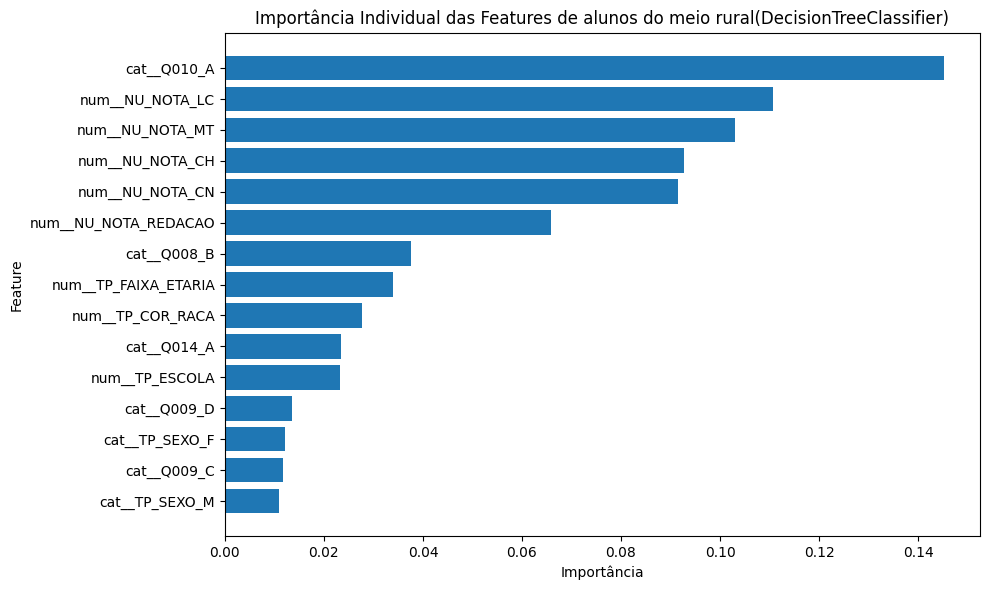

In [37]:
df_importancias_individuais_rural = analisar_importancia_features(modelo_rural, clf_rural, "de alunos do meio rural", top_n=15)


Resumo estatístico completo por classe social de alunos do meio rural:
               classe_social      media    mediana  desvio_padrao   variancia         q1         q3  valor_minimo  valor_maximo  amplitude  coef_var
      Até 2 salários mínimos 493.621240 505.880000      62.535877 3910.735850 447.920000 526.463908        163.80        759.36     595.56 12.668798
   De 2 a 3 salários mínimos 525.970863 526.463908      70.156111 4921.879918 477.820000 568.003247        214.24        759.22     544.98 13.338403
   De 3 a 6 salários mínimos 550.005271 539.680000      73.992214 5474.847690 501.820000 601.820000        226.38        790.16     563.78 13.453001
  De 6 a 10 salários mínimos 582.128025 581.620000      79.354733 6297.173681 526.463908 644.800000        351.02        810.62     459.60 13.631835
 De 10 a 15 salários mínimos 593.097925 593.600000      69.941805 4891.856129 532.060000 642.920000        425.64        727.26     301.62 11.792624
Acima de 15 salários mínimos 592.1

C:\Users\Carlos\AppData\Local\Temp\ipykernel_11964\4091095090.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[notas].mean(axis=1)


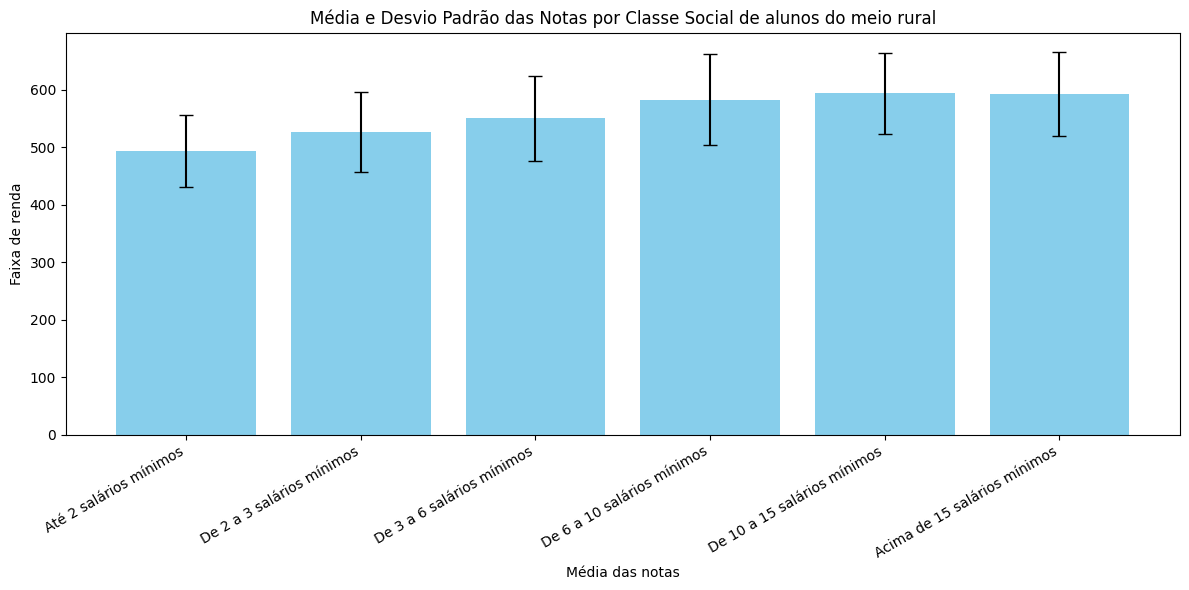

,classe_social,media,mediana,desvio_padrao,variancia,q1,q3,valor_minimo,valor_maximo,amplitude,coef_var,ordem
1,Até 2 salários mínimos,493.621240,505.880000,62.535877,3910.735850,447.920000,526.463908,163.80,759.36,595.56,12.668798,1
3,De 2 a 3 salários mínimos,525.970863,526.463908,70.156111,4921.879918,477.820000,568.003247,214.24,759.22,544.98,13.338403,2
4,De 3 a 6 salários mínimos,550.005271,539.680000,73.992214,5474.847690,501.820000,601.820000,226.38,790.16,563.78,13.453001,3
5,De 6 a 10 salários mínimos,582.128025,581.620000,79.354733,6297.173681,526.463908,644.800000,351.02,810.62,459.60,13.631835,4
2,De 10 a 15 salários mínimos,593.097925,593.600000,69.941805,4891.856129,532.060000,642.920000,425.64,727.26,301.62,11.792624,5
0,Acima de 15 salários mínimos,592.111112,579.090000,73.196715,5357.759111,527.690000,627.615000,445.36,766.32,320.96,12.361990,6


In [38]:
analisar_desempenho_por_classe(dataset_rural, "de alunos do meio rural")

In [39]:
# Filtrar apenas homens do meio rural
dataset_rural_homem = dataset_rural[dataset_rural['TP_SEXO'] == "M"]

# Filtrar apenas mulheres do meio rural
dataset_rural_mulher = dataset_rural[dataset_rural['TP_SEXO'] == "F"]

In [40]:
modelo_rural_homem, clf_rural_homem = treinar_modelo(dataset_rural_homem)

Acurácia: 0.9960782504383132

Relatório de classificação:
                               precision    recall  f1-score   support

Acima de 15 salários mínimos       1.00      1.00      1.00        46
      Até 2 salários mínimos       1.00      1.00      1.00     17100
 De 10 a 15 salários mínimos       1.00      1.00      1.00        74
   De 2 a 3 salários mínimos       1.00      0.97      0.98      1470
   De 3 a 6 salários mínimos       1.00      0.99      0.99      2651
  De 6 a 10 salários mínimos       1.00      0.99      1.00       333

                    accuracy                           1.00     21674
                   macro avg       1.00      0.99      0.99     21674
                weighted avg       1.00      1.00      1.00     21674


Matriz de confusão:
 [[   46     0     0     0     0     0]
 [    0 17098     0     0     2     0]
 [    0     0    74     0     0     0]
 [    0    48     0  1420     2     0]
 [    0    26     0     4  2621     0]
 [    0     3     0  

Importância das features (agregada):
Feature Q010: 0.1700
Feature num__NU_NOTA_LC: 0.1079
Feature num__NU_NOTA_MT: 0.0989
Feature num__NU_NOTA_CN: 0.0941
Feature num__NU_NOTA_CH: 0.0876
Feature num__NU_NOTA_REDACAO: 0.0653
Feature Q008: 0.0451
Feature num__TP_FAIXA_ETARIA: 0.0436
Feature Q009: 0.0342
Feature num__TP_COR_RACA: 0.0340
Feature Q019: 0.0306
Feature Q011: 0.0284
Feature Q014: 0.0270
Feature Q013: 0.0262
Feature num__TP_ESCOLA: 0.0210
Feature Q016: 0.0187
Feature Q015: 0.0166
Feature Q018: 0.0137
Feature Q007: 0.0128
Feature Q012: 0.0104


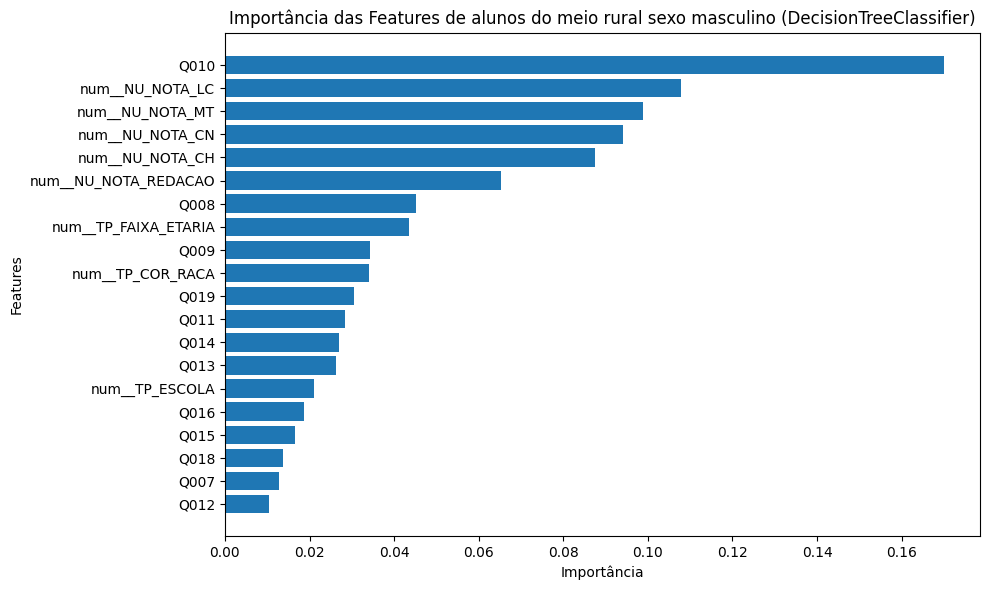

In [41]:
df_importancia_rural_homem = analisar_importancia_features_agregada(modelo_rural_homem,clf_rural_homem, "de alunos do meio rural sexo masculino", top_n=20)

Importância das features (sem agregação):
cat__Q010_A: 0.1550
num__NU_NOTA_LC: 0.1079
num__NU_NOTA_MT: 0.0989
num__NU_NOTA_CN: 0.0941
num__NU_NOTA_CH: 0.0876
num__NU_NOTA_REDACAO: 0.0653
num__TP_FAIXA_ETARIA: 0.0436
num__TP_COR_RACA: 0.0340
cat__Q008_B: 0.0329
cat__Q014_A: 0.0216
num__TP_ESCOLA: 0.0210
cat__Q009_D: 0.0144
cat__Q011_B: 0.0123
cat__Q013_B: 0.0109
cat__Q013_A: 0.0102
cat__Q009_C: 0.0098
cat__Q016_B: 0.0098
cat__Q015_A: 0.0098
cat__Q019_B: 0.0095
cat__Q019_C: 0.0091


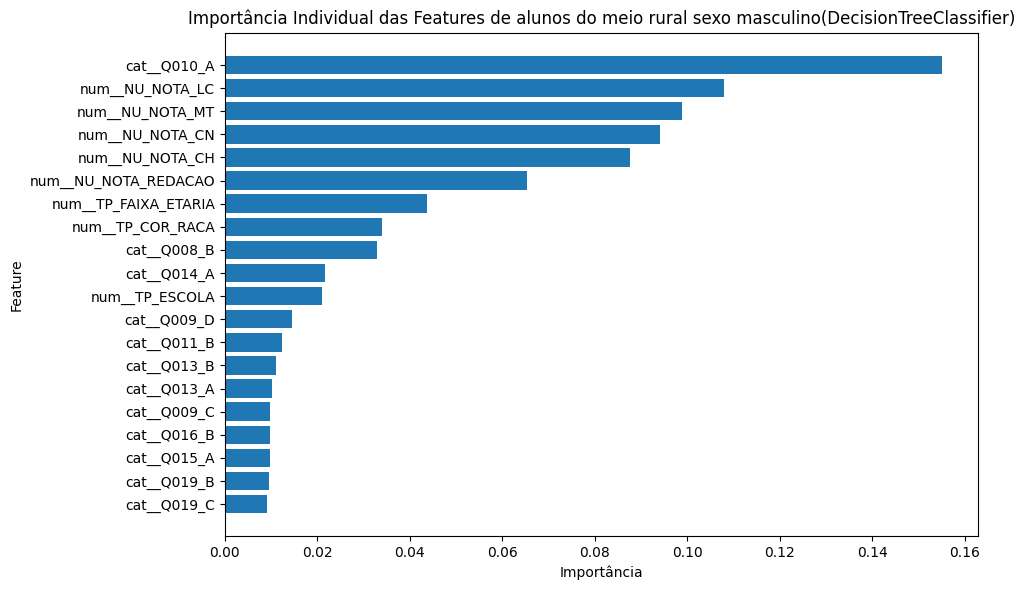

In [42]:
df_importancias_individuais_rural_homem = analisar_importancia_features(modelo_rural_homem, clf_rural_homem, "de alunos do meio rural sexo masculino", top_n=20)


Resumo estatístico completo por classe social de alunos do meio rural sexo masculino:
               classe_social      media    mediana  desvio_padrao   variancia         q1         q3  valor_minimo  valor_maximo  amplitude  coef_var
      Até 2 salários mínimos 494.830475 512.930000      65.214158 4252.886463 447.280000 526.463908        186.08        759.36     573.28 13.179091
   De 2 a 3 salários mínimos 524.098349 526.463908      74.394113 5534.483986 470.120000 568.720000        214.24        759.22     544.98 14.194686
   De 3 a 6 salários mínimos 547.573683 535.000000      75.572502 5711.203118 496.890000 599.980000        335.80        790.16     454.36 13.801339
  De 6 a 10 salários mínimos 579.760142 574.820000      79.958135 6393.303358 526.463908 642.300000        351.02        810.62     459.60 13.791589
 De 10 a 15 salários mínimos 595.728155 591.780000      70.504598 4970.898336 550.890000 651.400000        425.64        727.26     301.62 11.835029
Acima de 15 salário

C:\Users\Carlos\AppData\Local\Temp\ipykernel_11964\4091095090.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[notas].mean(axis=1)


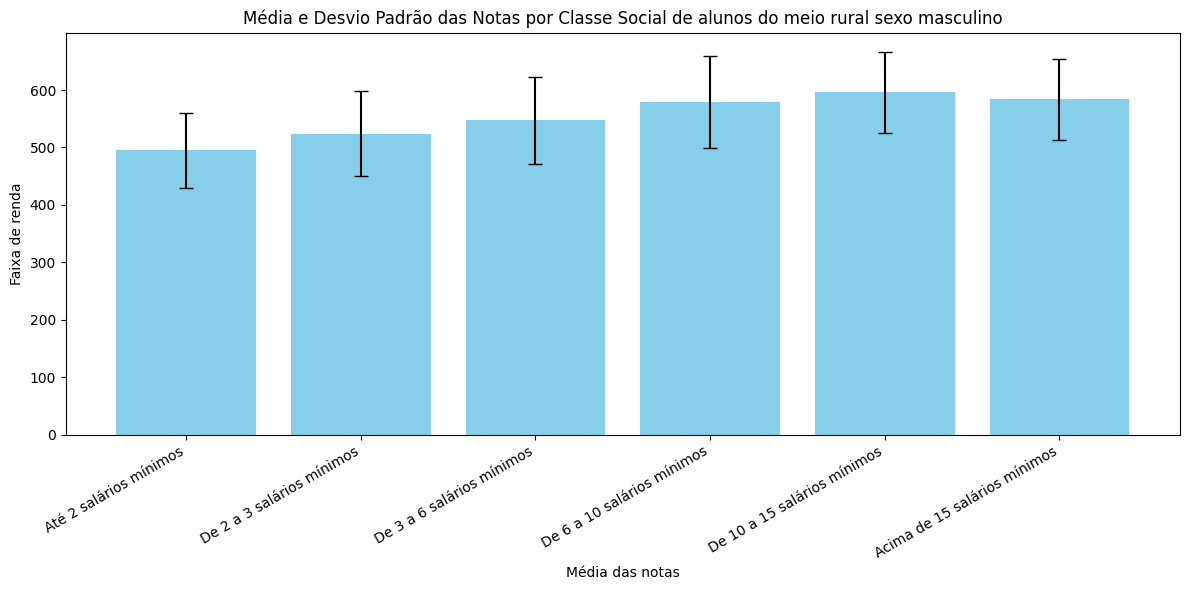

,classe_social,media,mediana,desvio_padrao,variancia,q1,q3,valor_minimo,valor_maximo,amplitude,coef_var,ordem
1,Até 2 salários mínimos,494.830475,512.930000,65.214158,4252.886463,447.280000,526.463908,186.08,759.36,573.28,13.179091,1
3,De 2 a 3 salários mínimos,524.098349,526.463908,74.394113,5534.483986,470.120000,568.720000,214.24,759.22,544.98,14.194686,2
4,De 3 a 6 salários mínimos,547.573683,535.000000,75.572502,5711.203118,496.890000,599.980000,335.80,790.16,454.36,13.801339,3
5,De 6 a 10 salários mínimos,579.760142,574.820000,79.958135,6393.303358,526.463908,642.300000,351.02,810.62,459.60,13.791589,4
2,De 10 a 15 salários mínimos,595.728155,591.780000,70.504598,4970.898336,550.890000,651.400000,425.64,727.26,301.62,11.835029,5
0,Acima de 15 salários mínimos,583.628941,575.190000,69.860255,4880.455290,526.617931,608.845000,445.36,766.32,320.96,11.969978,6


In [43]:
analisar_desempenho_por_classe(dataset_rural_homem, "de alunos do meio rural sexo masculino")

In [44]:
modelo_rural_mulher, clf_rural_mulher = treinar_modelo(dataset_rural_mulher)

Acurácia: 0.9969693689793268

Relatório de classificação:
                               precision    recall  f1-score   support

Acima de 15 salários mínimos       1.00      1.00      1.00        16
      Até 2 salários mínimos       1.00      1.00      1.00     23609
 De 10 a 15 salários mínimos       1.00      1.00      1.00        75
   De 2 a 3 salários mínimos       1.00      0.96      0.98      1482
   De 3 a 6 salários mínimos       1.00      0.99      0.99      2285
  De 6 a 10 salários mínimos       1.00      1.00      1.00       250

                    accuracy                           1.00     27717
                   macro avg       1.00      0.99      1.00     27717
                weighted avg       1.00      1.00      1.00     27717


Matriz de confusão:
 [[   16     0     0     0     0     0]
 [    0 23609     0     0     0     0]
 [    0     0    75     0     0     0]
 [    0    61     0  1421     0     0]
 [    0    21     0     2  2262     0]
 [    0     0     0  

Importância das features (agregada):
Feature Q010: 0.1432
Feature num__NU_NOTA_LC: 0.1204
Feature num__NU_NOTA_CH: 0.1022
Feature num__NU_NOTA_MT: 0.1017
Feature num__NU_NOTA_CN: 0.0936
Feature num__NU_NOTA_REDACAO: 0.0615
Feature Q008: 0.0519
Feature Q009: 0.0394
Feature num__TP_FAIXA_ETARIA: 0.0383
Feature num__TP_COR_RACA: 0.0297
Feature num__TP_ESCOLA: 0.0287
Feature Q019: 0.0285
Feature Q013: 0.0275
Feature Q011: 0.0266
Feature Q014: 0.0234
Feature Q016: 0.0192
Feature Q018: 0.0154
Feature Q007: 0.0123
Feature Q015: 0.0111
Feature Q012: 0.0106


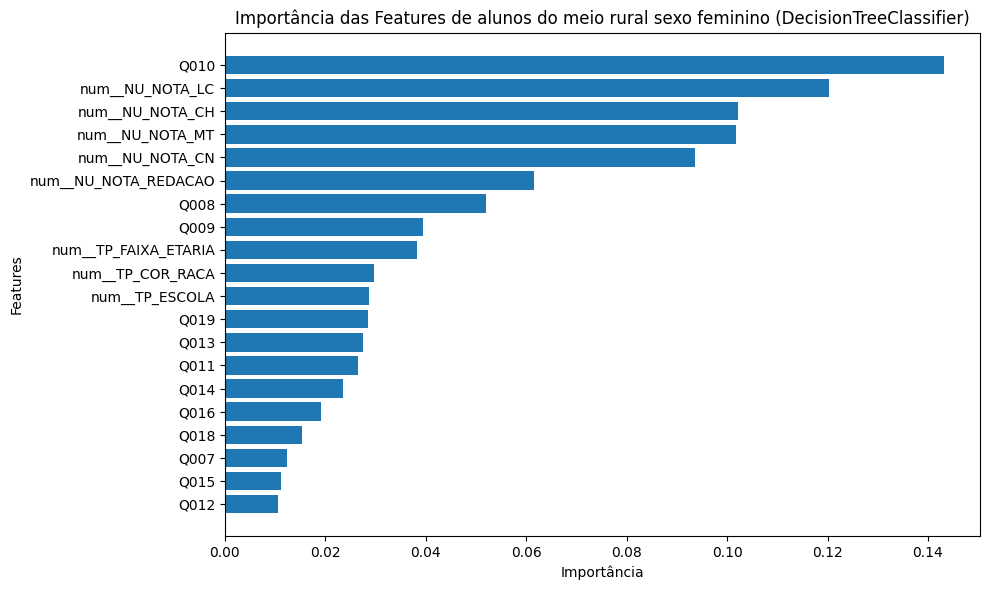

In [45]:
df_importancia_rural_mulher = analisar_importancia_features_agregada(modelo_rural_mulher,clf_rural_mulher, "de alunos do meio rural sexo feminino", top_n=20)

Importância das features (sem agregação):
cat__Q010_A: 0.1333
num__NU_NOTA_LC: 0.1204
num__NU_NOTA_CH: 0.1022
num__NU_NOTA_MT: 0.1017
num__NU_NOTA_CN: 0.0936
num__NU_NOTA_REDACAO: 0.0615
cat__Q008_B: 0.0409
num__TP_FAIXA_ETARIA: 0.0383
num__TP_COR_RACA: 0.0297
num__TP_ESCOLA: 0.0287
cat__Q014_A: 0.0185
cat__Q009_D: 0.0162
cat__Q016_A: 0.0139
cat__Q013_A: 0.0130
cat__Q009_C: 0.0127
cat__Q011_B: 0.0112
cat__Q019_B: 0.0101
cat__Q013_B: 0.0098
cat__Q011_A: 0.0097
cat__Q019_C: 0.0088


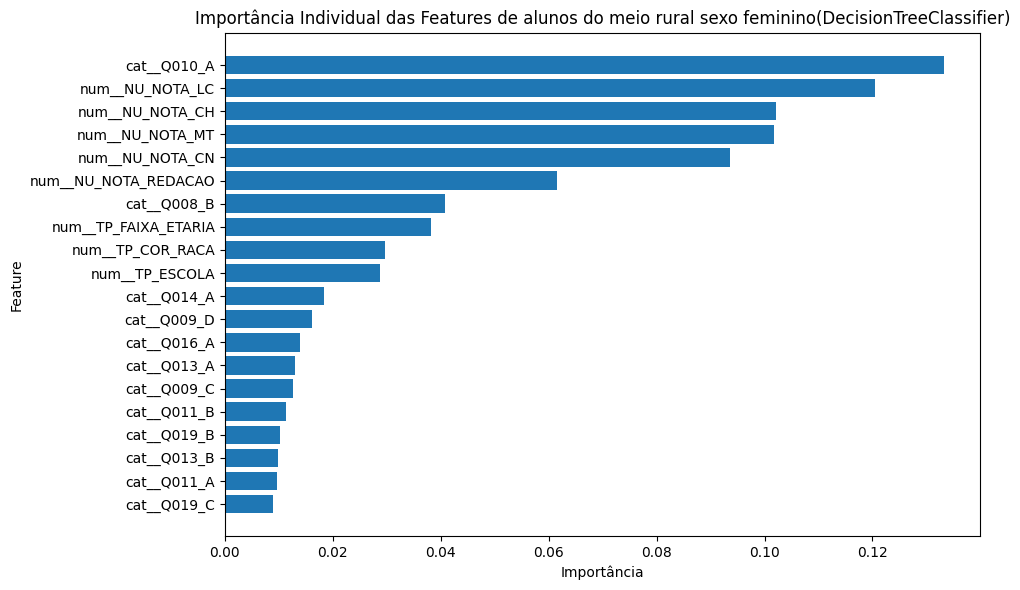

In [46]:
df_importancias_individuais_rural_mulher = analisar_importancia_features(modelo_rural_mulher, clf_rural_mulher, "de alunos do meio rural sexo feminino", top_n=20)


Resumo estatístico completo por classe social de alunos do meio rural sexo feminino:
               classe_social      media    mediana  desvio_padrao   variancia         q1         q3  valor_minimo  valor_maximo  amplitude  coef_var
      Até 2 salários mínimos 492.745391 501.200000      60.508342 3661.259495 448.220000 526.463908    163.800000        749.18 585.380000 12.279839
   De 2 a 3 salários mínimos 527.828214 526.463908      65.655392 4310.630556 484.735000 567.495000    351.800000        756.26 404.460000 12.438780
   De 3 a 6 salários mínimos 552.826339 543.560000      72.029091 5188.189902 507.557663 604.480000    226.380000        746.64 520.260000 13.029244
  De 6 a 10 salários mínimos 585.282046 585.590000      78.592649 6176.804486 526.463908 651.185000    398.717663        733.66 334.942337 13.428167
 De 10 a 15 salários mínimos 590.502765 597.980000      69.758471 4866.244247 526.463908 640.480000    460.960000        708.12 247.160000 11.813403
Acima de 15 salários

C:\Users\Carlos\AppData\Local\Temp\ipykernel_11964\4091095090.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[notas].mean(axis=1)


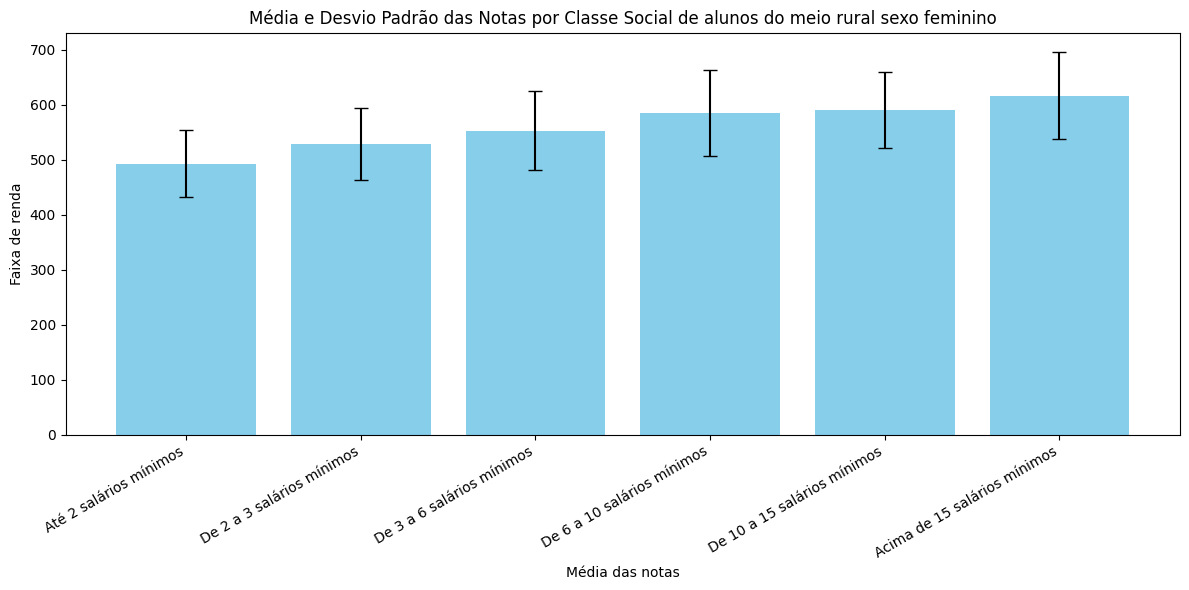

,classe_social,media,mediana,desvio_padrao,variancia,q1,q3,valor_minimo,valor_maximo,amplitude,coef_var,ordem
1,Até 2 salários mínimos,492.745391,501.200000,60.508342,3661.259495,448.220000,526.463908,163.800000,749.18,585.380000,12.279839,1
3,De 2 a 3 salários mínimos,527.828214,526.463908,65.655392,4310.630556,484.735000,567.495000,351.800000,756.26,404.460000,12.438780,2
4,De 3 a 6 salários mínimos,552.826339,543.560000,72.029091,5188.189902,507.557663,604.480000,226.380000,746.64,520.260000,13.029244,3
5,De 6 a 10 salários mínimos,585.282046,585.590000,78.592649,6176.804486,526.463908,651.185000,398.717663,733.66,334.942337,13.428167,4
2,De 10 a 15 salários mínimos,590.502765,597.980000,69.758471,4866.244247,526.463908,640.480000,460.960000,708.12,247.160000,11.813403,5
0,Acima de 15 salários mínimos,616.497354,622.740000,79.321382,6291.881621,551.049416,673.965000,495.420000,727.68,232.260000,12.866459,6


In [47]:
analisar_desempenho_por_classe(dataset_rural_mulher, "de alunos do meio rural sexo feminino")